<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Code-Setup" data-toc-modified-id="Code-Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Code Setup</a></span><ul class="toc-item"><li><span><a href="#Acronyms-and-abbreviations" data-toc-modified-id="Acronyms-and-abbreviations-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Acronyms and abbreviations</a></span></li></ul></li><li><span><a href="#Establish-Data-Frames" data-toc-modified-id="Establish-Data-Frames-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Establish Data Frames</a></span><ul class="toc-item"><li><span><a href="#Import-data-frame-headings" data-toc-modified-id="Import-data-frame-headings-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Import data frame headings</a></span></li><li><span><a href="#Read-organics-data" data-toc-modified-id="Read-organics-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Read organics data</a></span></li><li><span><a href="#Organics-dataframes" data-toc-modified-id="Organics-dataframes-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Organics dataframes</a></span><ul class="toc-item"><li><span><a href="#Imputation-for-density" data-toc-modified-id="Imputation-for-density-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Imputation for density</a></span></li><li><span><a href="#Continuous-data,-no-NAs" data-toc-modified-id="Continuous-data,-no-NAs-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Continuous data, no NAs</a></span></li><li><span><a href="#No-p-chem-data-(&quot;keeping&quot;-NAs)" data-toc-modified-id="No-p-chem-data-(&quot;keeping&quot;-NAs)-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>No p-chem data ("keeping" NAs)</a></span></li><li><span><a href="#WF-bins-as-alternative-target-variable" data-toc-modified-id="WF-bins-as-alternative-target-variable-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>WF bins as alternative target variable</a></span></li><li><span><a href="#Source-model" data-toc-modified-id="Source-model-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Source model</a></span></li></ul></li></ul></li><li><span><a href="#Performance-check-with-all-data-prior-to-pre-processing" data-toc-modified-id="Performance-check-with-all-data-prior-to-pre-processing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Performance check with all data prior to pre-processing</a></span><ul class="toc-item"><li><span><a href="#WF-Bins" data-toc-modified-id="WF-Bins-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>WF Bins</a></span></li><li><span><a href="#WF-Source" data-toc-modified-id="WF-Source-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>WF Source</a></span></li></ul></li><li><span><a href="#Pre-processing" data-toc-modified-id="Pre-processing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Pre-processing</a></span><ul class="toc-item"><li><span><a href="#Non-negative-Matrix-Factorization-(NMF)" data-toc-modified-id="Non-negative-Matrix-Factorization-(NMF)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Non-negative Matrix Factorization (NMF)</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>PCA</a></span><ul class="toc-item"><li><span><a href="#PCA-for-full-organics-model" data-toc-modified-id="PCA-for-full-organics-model-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>PCA for full organics model</a></span></li><li><span><a href="#PCA-for-source-model" data-toc-modified-id="PCA-for-source-model-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>PCA for source model</a></span></li></ul></li><li><span><a href="#Hierarchical-Agglomerative-Clustering-(HAC)" data-toc-modified-id="Hierarchical-Agglomerative-Clustering-(HAC)-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Hierarchical Agglomerative Clustering (HAC)</a></span><ul class="toc-item"><li><span><a href="#Alternate-clustering-approach" data-toc-modified-id="Alternate-clustering-approach-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>Alternate clustering approach</a></span></li><li><span><a href="#Helper-class-for-selecting-best-estimator" data-toc-modified-id="Helper-class-for-selecting-best-estimator-4.3.2"><span class="toc-item-num">4.3.2&nbsp;&nbsp;</span>Helper class for selecting best estimator</a></span></li><li><span><a href="#Helper-class-for-bins" data-toc-modified-id="Helper-class-for-bins-4.3.3"><span class="toc-item-num">4.3.3&nbsp;&nbsp;</span>Helper class for bins</a></span></li><li><span><a href="#Pipeline/GridSearch-to-select-n_clusters" data-toc-modified-id="Pipeline/GridSearch-to-select-n_clusters-4.3.4"><span class="toc-item-num">4.3.4&nbsp;&nbsp;</span>Pipeline/GridSearch to select n_clusters</a></span></li><li><span><a href="#Apply-feature-agglomeration-using-optimized-n_clusters" data-toc-modified-id="Apply-feature-agglomeration-using-optimized-n_clusters-4.3.5"><span class="toc-item-num">4.3.5&nbsp;&nbsp;</span>Apply feature agglomeration using optimized n_clusters</a></span></li></ul></li></ul></li><li><span><a href="#Core-models" data-toc-modified-id="Core-models-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Core models</a></span><ul class="toc-item"><li><span><a href="#Model-with-clustering,-regression" data-toc-modified-id="Model-with-clustering,-regression-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Model with clustering, regression</a></span></li><li><span><a href="#Model-with-PCA,-regression" data-toc-modified-id="Model-with-PCA,-regression-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Model with PCA, regression</a></span><ul class="toc-item"><li><span><a href="#Evaluate-model-without-product-categories" data-toc-modified-id="Evaluate-model-without-product-categories-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Evaluate model without product categories</a></span></li></ul></li><li><span><a href="#Model-with-PCA,-WF-Bins" data-toc-modified-id="Model-with-PCA,-WF-Bins-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Model with PCA, WF Bins</a></span><ul class="toc-item"><li><span><a href="#Optimize-SVC-RBF" data-toc-modified-id="Optimize-SVC-RBF-5.3.1"><span class="toc-item-num">5.3.1&nbsp;&nbsp;</span>Optimize SVC-RBF</a></span></li><li><span><a href="#Final-Organics-Model" data-toc-modified-id="Final-Organics-Model-5.3.2"><span class="toc-item-num">5.3.2&nbsp;&nbsp;</span>Final Organics Model</a></span></li></ul></li></ul></li></ul></div>

# Code Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os

In [2]:
# to make this notebook's output stable across runs
np.random.seed(42)

In [368]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [4]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_SAVE_DIR = "BLTfigs"

In [5]:
import os
#os.chdir(path)
if not (os.path.isdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)):
    print('Figure directory did not exist, creating now.')
    os.mkdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)
else:
    print('Figure directory exists.')

Figure directory exists.


In [6]:
def savepdf(fig,name):
    fig.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+name+'.pdf')

In [7]:
# To enable a specified sound to play
from IPython.display import Audio
sound_file = './data/Glass.wav'

# Add the following to the end of a cell with a long run time
# Play sound when cell is done running
Audio(url=sound_file, autoplay=True)

In [8]:
# Shift tab to understand function components
# Type questionmark before function to bring up help

## Acronyms and abbreviations

In [9]:
# arr = array
# df = dataframe
# enm = engineered nanomaterial
# mw = molecular weight
# NOC = not otherwise categorizable
# oecd = Organisation for Economic Co-operation and Development
# prop = property
# PUC = product use category
# wf = weight fraction

# Establish Data Frames

## Import data frame headings

In [439]:
# Import data frame headings from target model
enm_cols = []

# Open file of data frame headings and read the content into a list
#with open('./data/2018-10-31_enm-headers.txt', 'r') as filehandle: 
with open('./data/2018-10-31_final-headers.txt', 'r') as filehandle:  
    for line in filehandle:
        # remove linebreak which is the last character of the string
        currentCol = line[:-1]
        # add item to the list
        enm_cols.append(currentCol)

enm_cols

['propMW',
 'propMP',
 'propBP',
 'propDensity',
 'absorbent',
 'anti_adhesive_cohesive',
 'antioxidant',
 'antiredeposition_agent',
 'biocide',
 'brightener',
 'chemical_reaction_regulator',
 'colorant',
 'deodorizer',
 'filler',
 'flavouring_nutrient',
 'hardener',
 'humectant',
 'opacifier',
 'uv_stabilizer',
 'viscosity_modifier',
 'gen_AC',
 'gen_CP',
 'gen_EL',
 'gen_HM',
 'gen_PC',
 'gen_PE',
 'gen_VE',
 'group_childspecific',
 'group_dentalcare',
 'group_deodorant',
 'group_enginemaintenance',
 'group_fabrictreatmentanddye',
 'group_facialcleansingandmoisturizing',
 'group_fungicide',
 'group_generalhouseholdcleaning',
 'group_generalmoisturizing',
 'group_make-upandrelated',
 'group_paintstainandrelatedproducts',
 'group_sunscreen',
 'group_surfacesealers',
 'refined_spray',
 'matrix_F']

## Read organics data

In [453]:
# Read in weight fraction data and potential predictive variables
X_source = pd.read_csv("./data/WFdata_assignedfeatures.csv", sep=',', header='infer', usecols=range(1,88))

# Drop unwanted columns (index, CASRN, WF, product type, chem-props unused in ENM df)
X_source.drop(X_source.columns[[0,1,4,8,9,10,11,14,15,17]], axis=1, inplace=True)

# Rename columns
X_source.rename(columns = {'gencatID':'gen'}, inplace = True)
X_source.rename(columns = {'refined_product_type':'refined'}, inplace = True)
X_source.rename(columns = {'assignedID':'matrix'}, inplace = True)

print(X_source.shape)
#list(X_source.columns.values)

(29373, 77)


In [454]:
# Clean up data in refined column so it's only spray vs NOC
# TODO: May want to reinstate child column later on

# Find/replace sprays
#X_source['refined'] = X_source['refined'].replace('child|spray','spray', regex=True)
#X_source['refined'] = X_source['refined'].replace('gel|spray','spray', regex=True)
X_source.loc[X_source['refined'].str.contains("spray", na=False) == True, 'refined'] = "spray"

# Find/replace everything else with NOC
X_source.loc[X_source.refined != "spray", 'refined'] = "NOC"

# Check unique values for refined column
X_source.refined.unique()

# TODO: What's the difference between the line above and below?
# Produces error: A value is trying to be set on a copy of a slice from a DataFrame
#X_source.refined[X_source.refined != 'spray'] = 'NOC'

# TODO: Conditional replace using where (trying to improve on above code)
#https://stackoverflow.com/questions/21608228/conditional-replace-pandas
#X_source['refined'] = np.where(X_source[X_source['refined'].str.contains("spray", na=False)], "spray", "NOC")
#X_source['refined'] = X_source.where(X_source['refined'].str.contains("spray", na=False), "spray", "NOC")

array(['NOC', 'spray'], dtype=object)

In [455]:
#X_source.loc[34:38,]

In [456]:
# Transform factor data (product categories) into binary columns
X_source=pd.get_dummies(X_source, prefix=["gen","group","refined","matrix"], columns=["gen","group","refined","matrix"])

# Clean up column names
X_source.columns = X_source.columns.str.replace(' ','')
X_source.columns = X_source.columns.str.replace('/','')

In [457]:
# Remove all columns not used in ENM df ("enm_cols" list imported previously)
X_source = X_source[enm_cols]

# Delete rows that are missing important chemical property data
X_source = X_source[X_source['propMP'].notnull()] # delete missing data
print(X_source.shape)

# Delete rows that don't have enough data
#X_source_sub = X_source[X_source.iloc[:,4:].sum(axis=1) > 4]
#print(X_source_sub.shape)

(18466, 42)


In [458]:
# Preview final main dataframe
X_source.head(4)

,propMW,propMP,propBP,propDensity,absorbent,anti_adhesive_cohesive,antioxidant,antiredeposition_agent,biocide,brightener,...,group_facialcleansingandmoisturizing,group_fungicide,group_generalhouseholdcleaning,group_generalmoisturizing,group_make-upandrelated,group_paintstainandrelatedproducts,group_sunscreen,group_surfacesealers,refined_spray,matrix_F
0,498.572,215.2255,508.5280,1.528,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,106.168,-52.5218,147.1505,0.890,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,106.168,-52.5218,147.1505,0.890,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,106.168,-52.5218,147.1505,0.890,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,1


In [459]:
# Set maximum weight fraction as y array (target variable)
y_source = pd.read_csv("./data/WFdata_assignedfeatures.csv", sep=',', header='infer', usecols=[2,13])
y_source = y_source[y_source['propMP'].notnull()]
y_source.drop(y_source.columns[1], axis=1, inplace=True)

print(y_source.shape)

(18466, 1)


##  Organics dataframes

I split up X_source into a few separate dataframes for doing separate hierarchical clustering later on.

### Imputation for density

https://medium.com/ibm-data-science-experience/missing-data-conundrum-exploration-and-imputation-techniques-9f40abe0fd87

In [467]:
# How much density data is missing?
print(X_source[~X_source['propDensity'].notnull()].shape)

# Create data frame with missing density data deleted
X_source_woimp = X_source[X_source['propDensity'].notnull()] # delete missing data
print(X_source_woimp.shape)

(0, 42)
(18466, 42)


In [468]:
# Percent of density data missing
676/18466

0.036607819776887256

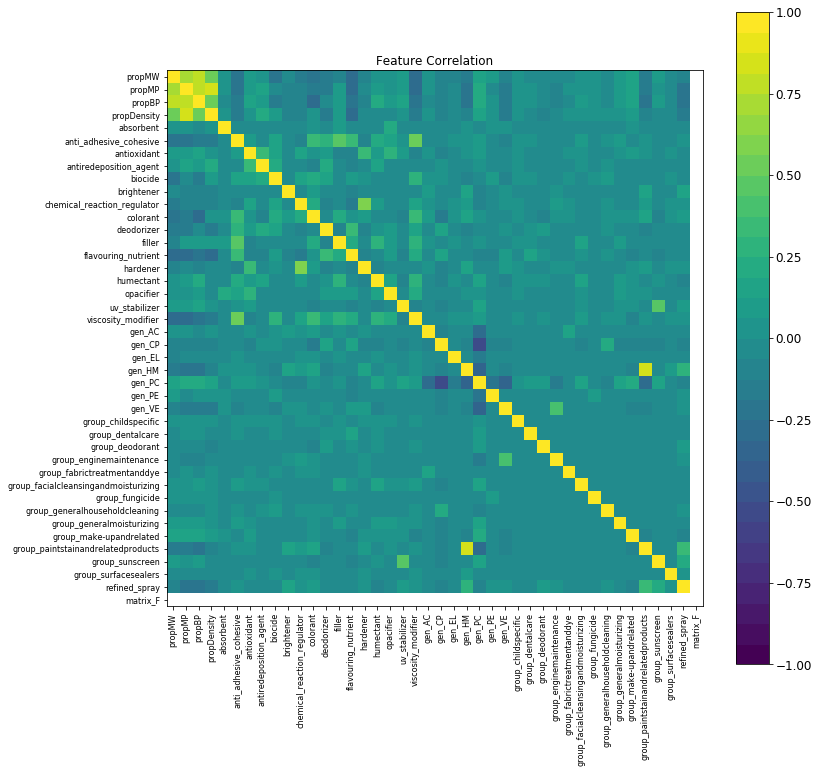

In [469]:
# Check correlations between features
def correlation_matrix(df):

    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    cmap = cm.get_cmap('viridis', 32) #colorscale='jet'
    cax = ax.imshow(df.corr(), cmap=cmap, vmin=-1, vmax=1)
#    ax.grid(True)
    plt.title('Feature Correlation')
    labels = X_source.columns.tolist()
    ax.set_xticks(range(len(df.columns)))
    ax.set_yticks(range(len(df.columns)))
    ax.set_xticklabels(labels,fontsize=8, rotation=90)
    ax.set_yticklabels(labels,fontsize=8)
    fig.colorbar(cax)
    plt.show()

correlation_matrix(X_source)

In order to find missing values for density, imputation will be performed using linear regression. Melting point has the highest correlation with density and will therefore be used as the independent variable.
Assuming the line of best fit for a set of points is given by:

$y = a + b x$

where:

$b = \Large{\frac{\sum x_i  y_i - n \bar x\bar y )} {\sum (x_i - \bar x)^2}} $

and

$a = \bar y - b \bar x$

To remove outliers: https://www.kdnuggets.com/2017/02/removing-outliers-standard-deviation-python.html

In [470]:
# Find line of best fit for imputation
X = np.array(X_source.loc[X_source.propDensity.notnull(), ['propMP']])
Y = np.array(X_source.loc[X_source.propDensity.notnull(), ['propDensity']])

# solve for a and b
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum(xi*yi for xi,yi in zip(X, Y)) - n * xbar * ybar
    denum = sum(xi**2 for xi in X) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    return a, b

# Solution
best_fit(X, Y)

(array([1.00785901]), array([0.00235638]))

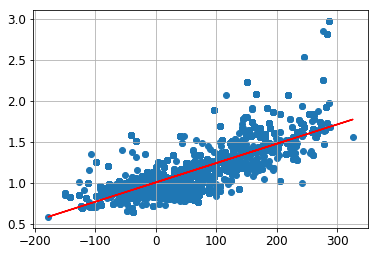

In [471]:
# Plot points and fit line
%matplotlib inline
plt.scatter(X, Y)
yfit = [a + b * xi for xi in X]
plt.plot(X, yfit, color='r')
plt.grid()
plt.show()

In [472]:
# Put imputed densities into data frame
for idx in X_source.index:
    if pd.isnull(X_source.loc[idx,"propDensity"]):
        MP = X_source.loc[idx,"propMP"]
        X_source.loc[idx,"propDensity"] = (b * MP + a)

### Continuous data, no NAs

In [16]:
# Dataframe for feature reduction (functions and product categories only)
X=pd.DataFrame(X_source)
# Drop chemical property features
X.drop(X.columns[[0,1,2,3,4,5,6,7,8,9,10]], axis=1, inplace=True)
feat_names=list(X.columns.values)
#func_names=list(X.columns.values[11:80])
#PUC_names=list(X.columns.values[81:])
#feat_names
#X.loc[0:3,]

In [17]:
# Array for feature reduction (functions and product categories only)
X=np.array(X)
print(X.shape)

(18466, 277)


In [18]:
# Dataframe for only functional use categories
Xf=pd.DataFrame(X_source)
# Drop unwanted columns
Xf.drop(Xf.columns[0:10], axis=1, inplace=True) # drop chem props
Xf.drop(Xf.columns[62:], axis=1, inplace=True) # drop product categories
func_names=list(Xf.columns.values)
#func_names
Xf.loc[0:3,]

,abrasive,absorbent,adhesion_cohesion_promoter,anti_adhesive_cohesive,antifreeze_agent,antiredeposition_agent,antiscaling_agent,antistatic_agent,antioxidant,antiseborrheic,...,softener_conditioner,solubility_enhancer,solvent,stabilizing_agent,surface_modifier,surfactant,uv_stabilizer,viscosity_modifier,waterproofing_agent,wetting_agent
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
func_names

['abrasive',
 'absorbent',
 'adhesion_cohesion_promoter',
 'anti_adhesive_cohesive',
 'antifreeze_agent',
 'antiredeposition_agent',
 'antiscaling_agent',
 'antistatic_agent',
 'antioxidant',
 'antiseborrheic',
 'binder',
 'biocide',
 'bleaching_agent',
 'brightener',
 'chelating_agent',
 'chemical_reaction_regulator',
 'cleaning_agent',
 'colorant',
 'corrosion_inhibitor',
 'crystal_growth_modifier',
 'defoamer',
 'dehydrating_agent',
 'deodorizer',
 'diluent',
 'dispersing_agent',
 'dust_suppressant',
 'dusting_agent',
 'emulsifier',
 'filler',
 'film_former',
 'flame_retardant',
 'flavouring_nutrient',
 'foamant',
 'fragrance',
 'hardener',
 'heat_stabilizer',
 'heat_transferring_agent',
 'humectant',
 'intermediate',
 'ion_exchange_agent',
 'monomer',
 'opacifier',
 'oxidizing_agent',
 'pH_regulating_agent',
 'photosensitizer',
 'plasticizer',
 'polymerization_promoter',
 'preservative',
 'processing_aid',
 'propellant',
 'reducing_agent',
 'sizing_agent',
 'softener_conditioner',


In [20]:
# Array for only functional use categories
Xf=np.array(Xf)
print(Xf.shape)

(18466, 62)


In [21]:
# Array for only product categories
Xp=pd.DataFrame(X_source)
# Drop unwanted columns
Xp.drop(Xp.columns[0:73], axis=1, inplace=True)
PUC_names=list(Xp.columns.values)
#PUC_names
Xp.loc[0:3,]

,group_adhesives and adhesive removers,group_air freshener,group_all pets,group_auto body work,group_bathroom,group_boat care and maintenance,group_body care set,group_body hygiene,group_body paint,group_body powder,...,refined_gel,refined_interior,refined_liquid,refined_mousse,refined_oil or diffuse,refined_ph control,refined_powder,refined_shock,refined_solid,refined_spray
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [22]:
# Array for only product categories
Xp=np.array(Xp)
print(Xp.shape)

(18466, 215)


In [23]:
# Array for only chemical properties
Xc=pd.DataFrame(X_source)
# Drop unwanted columns
Xc.drop(Xc.columns[11:], axis=1, inplace=True)
chemprop_names=list(Xc.columns.values)
#chemprop_names

Xc=np.array(Xc)
print(Xc.shape)

(18466, 11)


In [24]:
# Set maximum weight fraction as y array (target variable)
y = y_source.values.ravel()
#y.loc[0:3,]
print(y.shape)

# Maximum weight fraction as LOG TRANSFORMED y array
########### NOTE*****************
########### Predictions get bad around 10^-5.
########### Therefore, 10^-5 was added to all weight
########### fractions to improve model performance.
########### Results around this value may be
########### unreliable.
y_log = np.log10(y)
y_log_cut = np.log10(y+0.00001)

(18466,)


(array([ 15393.,    988.,    691.,    410.,    141.,    278.,    149.,
           116.,     53.,    247.]),
 array([  1.00000000e-09,   1.00000001e-01,   2.00000001e-01,
          3.00000001e-01,   4.00000001e-01,   5.00000000e-01,
          6.00000000e-01,   7.00000000e-01,   8.00000000e-01,
          9.00000000e-01,   1.00000000e+00]),
 <a list of 10 Patch objects>)

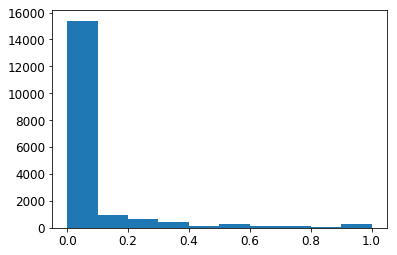

In [25]:
# Histogram of weight fractions
plt.hist(y)

(array([  3.00000000e+00,   1.09000000e+02,   1.40000000e+01,
          4.70000000e+01,   9.90000000e+01,   2.66000000e+02,
          1.61800000e+03,   5.58600000e+03,   7.73300000e+03,
          2.99100000e+03]),
 array([-9. , -8.1, -7.2, -6.3, -5.4, -4.5, -3.6, -2.7, -1.8, -0.9,  0. ]),
 <a list of 10 Patch objects>)

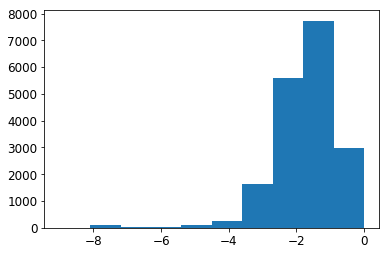

In [26]:
# Log-transformed histogram of weight fraction
plt.hist(y_log, bins=10)

(array([  274.,   182.,   302.,  1719.,  4447.,  6127.,  3370.,  2045.]),
 array([ -4.99995657e+00,  -4.37496146e+00,  -3.74996634e+00,
         -3.12497123e+00,  -2.49997611e+00,  -1.87498100e+00,
         -1.24998589e+00,  -6.24990772e-01,   4.34292310e-06]),
 <a list of 8 Patch objects>)

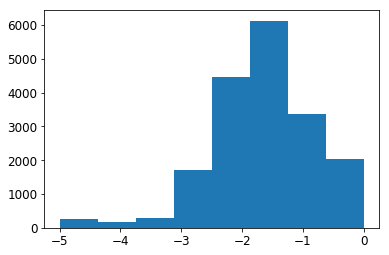

In [27]:
# Log-transformed histogram of weight fraction
plt.hist(y_log_cut, bins=8)

### No p-chem data ("keeping" NAs)

1/3 of the data is lost by excluding NAs, which are only found in the chemical property columns. Here I'll restructure my dataframes to exclude chemical property data and keep all of the ~30,000 tuples. Later on I'll test the performance without chemical property data, and it explains 5% less variance. In conclusion, getting rid of the NAs (keeping chemical property data) is better.

In [181]:
# Read in all data without dropping NAs
X_source_all=pd.read_csv("./data/X_source_assignedfeatures.csv", sep=',', header='infer', usecols=range(1,87))

# Drop unwanted columns (index, CASRN, 2/5 product category components)
X_source_all.drop(X_source_all.columns[[0,1,2,6]], axis=1, inplace=True)

# Rename columns
X_source_all.rename(columns = {'product_type':'product'}, inplace = True)
X_source_all.rename(columns = {'refined_product_type':'refined'}, inplace = True)

# Assign correct data types
X_source_all['group'] = X_source_all['group'].astype('object')
X_source_all['product'] = X_source_all['product'].astype('object')
X_source_all['refined'] = X_source_all['refined'].astype('object')
#X_source_all.dtypes
print(X_source_all.shape)

(29373, 82)


In [182]:
# Transform factor data (product categories) into binary columns
X_source_all=pd.get_dummies(X_source_all, prefix=["group","product","refined"], columns=["group","product","refined"])

# Relocate data for duplicative columns
X_source_all.columns = X_source_all.columns.str.replace('|','_')
X_source_all.loc[X_source_all.refined_child_spray == 1, ['refined_child', 'refined_spray']] = 1, 1
X_source_all.loc[X_source_all.refined_gel_spray == 1, ['refined_gel', 'refined_spray']] = 1, 1

# Get counts for columns
colsum2 = X_source_all.sum(axis=0)
colsum2.to_csv('./BLTfigs/X_source_colsum2.csv')

# Delete the following features:
    # chemical property columns
    # columns with <10 hits
    # child_spray [380] and gel_spray [384] columns (duplicative)
X_source_all.drop(X_source_all.columns[[9]],
            axis=1, inplace=True) # drop density
X_source_all.drop(X_source_all.columns[[0,1,2,3,4,5,6,7,8,9,108,115,142,166,175,188,214,255,316,326,344,371,135,189,191,228,264,360,116,141,153,157,190,259,311,323,349,354,83,128,139,173,177,220,290,308,370,375,119,170,263,318,154,184,320,342,350,227,270,277,309,101,155,158,163,221,232,245,351,355,365,372,125,167,201,271,347,373,49,89,145,152,165,204,267,322,380,384]],
            axis=1, inplace=True) # drop all other stuff

print(X_source_all.shape)

X_all=np.array(X_source_all)

(29373, 305)


In [183]:
# Set maximum weight fraction as y_all array
# Log-transform
y_all=pd.read_csv("./data/X_source_assignedfeatures.csv", sep=',', header='infer', usecols=[2])
y_all=y_all.values.ravel()
print(y_all.shape)
y_all=np.log(y_all)

(29373,)


### WF bins as alternative target variable

Right now weight fraction is a continuous variable. This will make it categorical, as implemented in Isaacs et al. 2016.

Resources for implementing classifier with categorical target:

https://stackoverflow.com/questions/30271257/categorical-numerical-features-categorical-target-scikit-learn-python

https://stackoverflow.com/questions/21702342/creating-a-new-column-based-on-if-elif-else-condition

https://www.quora.com/Does-random-forest-works-with-categorical-variables

https://chrisalbon.com/machine_learning/preprocessing_structured_data/convert_pandas_categorical_column_into_integers_for_scikit-learn/

In [26]:
# Define function to assign weight fractions to bins per Isaacs et al. 2016
def bins(row):
    if row['maximum_weight_fraction'] <= 0.005:
        val = 'bottom'
    elif row['maximum_weight_fraction'] > 0.05:
        val = 'top'
    else:
        val = 'middle'
    return val
y_source['wfbin'] = y_source.apply(bins, axis=1)

Text(0.5,1,'Frequency of Chemical Weight Fraction Bins')

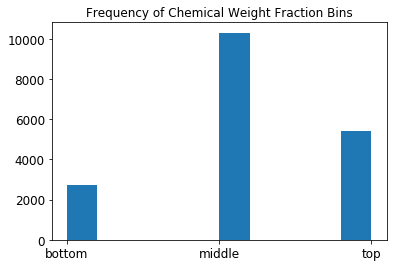

In [27]:
plt.hist(y_source['wfbin'])
plt.title('Frequency of Chemical Weight Fraction Bins')

Text(0.5,1,'Frequency of Chemical Weight Fraction Bins in Isaacs et al. 2016')

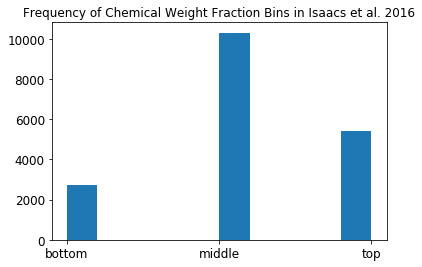

In [28]:
plt.hist(y_source['wfbin'])
plt.title('Frequency of Chemical Weight Fraction Bins in Isaacs et al. 2016')

In [29]:
# Use label encoder to make bins compatible with Scikit-Learn
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# Fit the encoder to the categorical column
bin_num = le.fit_transform(y_source['wfbin'])
# Transform categories into integers
le.transform(y_source['wfbin'])
# Convert a list of integers into their category names
print('[0, 1, 2]')
print(list(le.inverse_transform([0,1,2])))
print('bin_num shape: {}'.format(bin_num.shape))

[0, 1, 2]
['bottom', 'middle', 'top']
bin_num shape: (18466,)


### Source model

In [28]:
# Dataframe for source model
X_source_source=pd.DataFrame(X_source)
# Drop all chemical property features except MW, solubility
X_source_source.drop(X_source_source.columns[[1,2,3,4,5,6,7,10]], axis=1, inplace=True)

X_source_source.loc[0:3,]
#print(X_source_source.shape)

,propMW,propSolubility,propBCF,absorbent,adhesion_cohesion_promoter,anti_adhesive_cohesive,antifreeze_agent,antiredeposition_agent,antiscaling_agent,antistatic_agent,...,refined_gel,refined_interior,refined_liquid,refined_mousse,refined_oil or diffuse,refined_ph control,refined_powder,refined_shock,refined_solid,refined_spray
0,498.572,0.003361,7.66712,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,106.168,0.002197,87.66770,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,106.168,0.002197,87.66770,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,106.168,0.002197,87.66770,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


Arrays for only functions and only product categories are the same as for the full organics model. The only difference is the chemical property array, since this has been cut from 10 features down to 2.

In [29]:
# Array for only chemical properties (MW and solubility)
Xsc=pd.DataFrame(X_source_source)
# Drop unwanted columns
Xsc.drop(Xsc.columns[3:], axis=1, inplace=True)

Xsc=np.array(Xsc)
print(Xsc.shape)

(18466, 3)


# Performance check with all data prior to pre-processing

I already know SVR-RBF is the best performing, on average, based on later results. I'll test this with all of the data to get a baseline measure of how well I can make predictions. Because weight fraction is not normally distributed, I tried the log-transformed target, too--it performed much better.

## WF Bins

In [434]:
# REDID w/ cv=5

# CLASSIFIER: SVC-RBF with all features, normalized
    # Weight fraction bins
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=5
n_jobs=3
c_set=[1,5]
gamma_set=[0.0001,0.001]

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_source,bin_num)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 1, 'estimator__gamma': 0.001}
0.662081663598


In [124]:
# REDID w/ cv=5

# CLASSIFIER: SVC-RBF with all features, normalized
    # Weight fraction bins
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=5
n_jobs=3
c_set=[1,5]
gamma_set=[0.0001,0.001]

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_source,bin_num)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 1, 'estimator__gamma': 0.001}
0.686775695873


In [91]:
# CLASSIFIER: SVC-RBF with all features, normalized
    # Weight fraction bins
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=4
n_jobs=3
c_set=[1,10]
gamma_set=[0.0001,0.001]

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_source,bin_num)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 1, 'estimator__gamma': 0.001}
0.699880862125


In [92]:
# CLASSIFIER: SVC-RBF with all features, normalized
    # Weight fraction bins
    # Explained variance
    # Additional parameter settings

# Pipeline
estimator = SVC(kernel='rbf')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=4
n_jobs=3
c_set=[1,3]
gamma_set=[0.001]

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_source_source,bin_num)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 3, 'estimator__gamma': 0.001}
0.705404527239


SVC-RBF best settings so far:

For c_set=[0.1,1,5] --> C=1

For gamma_set=[0.0001,0.001,0.01] --> gamma=0.001

## WF Source

In [125]:
# REDID w/ cv=5

# SVR-RBF with all features, normalized
    # Log-transformed weight fractions
    # Explained variance

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

# Pipeline
estimator = SVR(kernel='rbf')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=5
n_jobs=3
c_set=[1,5]
gamma_set=[0.0001,0.001]

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='explained_variance', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_source_source,y_log)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when cell is done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 5, 'estimator__gamma': 0.001}
0.238494074174


In [66]:
# SVR-RBF with all features, normalized
    # Log-transformed weight fractions
    # Explained variance

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

# Pipeline
estimator = SVR(kernel='rbf')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=4
n_jobs=3
c_set=[1]
gamma_set=[0.0001,0.001]

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='explained_variance', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_source_source,y_log)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when cell is done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 1, 'estimator__gamma': 0.001}
0.206772018116


In [126]:
# REDID w/ cv=5

# SVR-RBF with all features, normalized
    # Log-transformed weight fractions + 10^-5 to improve performance
    # Explained variance

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

# Pipeline
estimator = SVR(kernel='rbf')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=5
n_jobs=3
c_set=[1,5]
gamma_set=[0.0001, 0.001]

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='explained_variance', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_source_source,y_log_cut)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when cell is done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 5, 'estimator__gamma': 0.001}
0.272652692912


In [86]:
# SVR-RBF with all features, normalized
    # Log-transformed weight fractions + 10^-5 to improve performance
    # Explained variance

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

# Pipeline
estimator = SVR(kernel='rbf')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=4
n_jobs=3
c_set=[1]
gamma_set=[0.001]

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='explained_variance', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_source_source,y_log_cut)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when cell is done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 1, 'estimator__gamma': 0.001}
0.252255462005


In [82]:
# SVR-RBF with only function, normalized
    # Log-transformed weight fractions + 10^-5 to improve performance
    # Explained variance

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

# Pipeline
estimator = SVR(kernel='rbf')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=4
n_jobs=3
c_set=[1]
gamma_set=[0.0001,0.001]

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='explained_variance', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(Xf,y_log_cut)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when cell is done running
Audio(url=sound_file, autoplay=True)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.

{'estimator__C': 1, 'estimator__gamma': 0.001}
0.18108440507


In [129]:
# CLASSIFIER: SVC-RBF with all features, normalized
    # Weight fraction bins
    # Explained variance
    # Additional parameter settings

# Pipeline
estimator = SVC(kernel='rbf')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=5
n_jobs=3
c_set=[1,5]
gamma_set=[0.0001,0.001]

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_source_source,bin_num)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 1, 'estimator__gamma': 0.001}
0.673453915304


In [93]:
# CLASSIFIER: SVC-RBF with all features, normalized
    # Weight fraction bins
    # Accuracy
    # Additional parameter settings

# Pipeline
estimator = SVC(kernel='rbf')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=4
n_jobs=3
c_set=[1,5]
gamma_set=[0.001]

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_source_source,bin_num)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 1, 'estimator__gamma': 0.001}
0.698202101159


Before adjusting y_log.

In [68]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition
from sklearn.svm import SVC

In [69]:
bestpipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('feat', decomposition.PCA(n_components=46)),
    ('estimator', SVR(kernel='rbf', C=5, gamma=0.0003))
     ])
bestpipe.fit(X_source_source,y_log)

In [70]:
y_predict = bestpipe.predict(X_source_source)

In [96]:
# BEFORE
from statistics import mean

xs = y_log
ys = y_predict

def best_fit_slope_and_intercept(xs,ys):
    m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /
         ((mean(xs)*mean(xs)) - mean(xs*xs)))
    b = mean(ys) - m*mean(xs)
    return m, b
def squared_error(ys_orig,ys_line):
    return sum((ys_line - ys_orig) * (ys_line - ys_orig))
def coefficient_of_determination(ys_orig,ys_line):
    y_mean_line = [mean(ys_orig) for y in ys_orig]
    squared_error_regr = squared_error(ys_orig, ys_line)
    squared_error_y_mean = squared_error(ys_orig, y_mean_line)
    return 1 - (squared_error_regr/squared_error_y_mean)

regression_line = [(m*x)+b for x in xs]
r_squared = coefficient_of_determination(ys,regression_line)

m, b = best_fit_slope_and_intercept(xs,ys)
r_squared = coefficient_of_determination(ys,regression_line)
print('slope={}; y-intercept={}; R^2={}'.format(m,b,r_squared))
#print(m,b)

slope=0.2558232747330535; y-intercept=-1.1224159415263257; R^2=0.2934935303788683


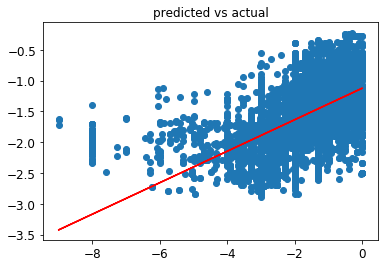

In [76]:
#plt.plot(np.unique(y_log), np.poly1d(np.polyfit(y_log, y_predict, 1))(np.unique(y_log)), )
plt.scatter(y_log,y_predict)
plt.plot(xs, regression_line, color='red')
plt.title('predicted vs actual')
plt.show()

After adjusting y_log by adding 10^-5.

In [77]:
bestpipe2 = Pipeline([
    ('scale', MinMaxScaler()),
    ('feat', decomposition.PCA(n_components=46)),
    ('estimator', SVR(kernel='rbf', C=5, gamma=0.0003))
     ])
bestpipe2.fit(X_source_source,y_log_cut)

Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feat', PCA(copy=True, iterated_power='auto', n_components=46, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('estimator', SVR(C=5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0003,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [78]:
y_predict_cut = bestpipe2.predict(X_source_source)

In [106]:
xs = y_log_cut
ys = y_predict_cut

m, b = best_fit_slope_and_intercept(xs,ys)
regression_line = [(m*x)+b for x in xs]
r_squared = coefficient_of_determination(ys,regression_line)
#print(m,b)
print('slope={}; y-intercept={}; R^2={}'.format(m,b,r_squared))

slope=0.31610145357802666; y-intercept=-1.031042945820617; R^2=0.36906457025614003


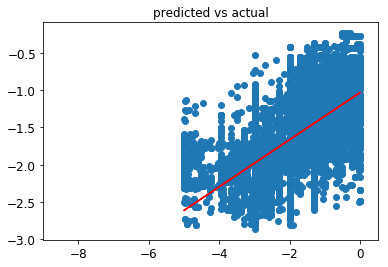

In [128]:
#plt.plot(np.unique(y_log), np.poly1d(np.polyfit(y_log, y_predict, 1))(np.unique(y_log)), )
plt.scatter(y_log_cut,y_predict_cut)
plt.plot(xs, regression_line, color='red')
plt.title('predicted vs actual')
plt.xlim([-9,0.5])
plt.show()

# Pre-processing

## Non-negative Matrix Factorization (NMF)

I never got this code to work.

http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF

https://www.sciencedirect.com/science/article/pii/S0925231211006370

https://stats.stackexchange.com/questions/200699/evaluate-performance-of-non-negative-matrix-factorization-nmf

In [40]:
# Scale the data first (i.e., the chemical properties) so everything is from 0 to 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
wf_scaled = scaler.fit_transform(X_source)
wf_scaleddf = pd.DataFrame(data=wf_scaled)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [154]:
from sklearn import decomposition
nmf=decomposition.NMF(n_components=30)
S=nmf.fit_transform(wf_scaled)

In [156]:
fig=plt.figure()
plt.plot(n_components,nmf.reconstruction_err_,'.-',label='NMF')
#plt.plot([0, S.shape[1]],[.70,.70],'k',label='70%')
#plt.plot([0, S.shape[1]],[.85,.85],'r',label='85%')
#plt.xlim([15,55])
plt.xlabel('Coefficient Number')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid()
plt.legend()
plt.show()

NameError: name 'n_components' is not defined

## PCA

http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA

***Need to add in cross-validation***

In [533]:
# Scale the data first (i.e., the chemical properties) so everything is from 0 to 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
wf_scaled = scaler.fit_transform(X_source)
wf_source_scaled = scaler.fit_transform(X_source_source)

### PCA for full organics model

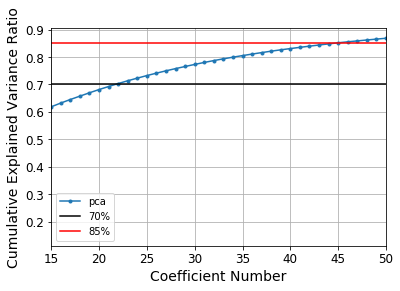

In [534]:
# Figure out number of components to achieve 85% cumulative explained variance
from sklearn import decomposition 
pca=decomposition.PCA(n_components=51)
dim_red=pca.fit(wf_scaled)

fig =plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_),'.-',label='pca')
plt.plot([0, 50],[.70,.70],'k',label='70%')
plt.plot([0, 50],[.85,.85],'r',label='85%')
plt.xlim([15,50])
plt.xlabel('Coefficient Number')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid()
plt.legend()
plt.show()

Most of the variance can be explained using 46 components in PCA. 

I also wanted to look at a simple breakdown of a 2-component PCA to see which features explained the most variance.

In [175]:
# PCA, 2 component
pca = decomposition.PCA(n_components=2)
pca.fit_transform(wf_scaled)

# Dump components relations with features:
#https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn
pca_df = pd.DataFrame(pca.components_,columns=X_source.columns,index = ['PC-1','PC-2'])
pca_df.to_csv('./BLTfigs/X_source_pca2component.csv')

In [30]:
# Transform/apply PCA
from sklearn import decomposition 
pca=decomposition.PCA(n_components=46)
dim_red=pca.fit_transform(wf_scaled)

### PCA for source model

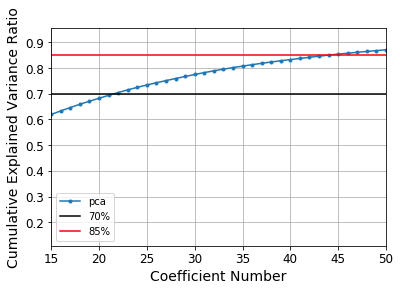

In [177]:
# Figure out number of components to achieve 85% cumulative explained variance
from sklearn import decomposition 
pca=decomposition.PCA(n_components=70)
dim_red_source=pca.fit(wf_source_scaled)

fig =plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_),'.-',label='pca')
plt.plot([0, 50],[.70,.70],'k',label='70%')
plt.plot([0, 50],[.85,.85],'r',label='85%')
plt.xlim([15,50])
plt.xlabel('Coefficient Number')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid()
plt.legend()
plt.show()

Most of the variance can be explained using 45 components in PCA. 

I also wanted to look at a simple breakdown of a 2-component PCA to see which features explained the most variance.

In [ ]:
# Figure out number of components to achieve 85% cumulative explained variance
from sklearn import decomposition 
pca=decomposition.PCA(n_components=70)
dim_red_source=pca.fit(wf_source_scaled)

fig =plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_),'.-',label='pca')
plt.plot([0, 50],[.70,.70],'k',label='70%')
plt.plot([0, 50],[.85,.85],'r',label='85%')
plt.xlim([15,50])
plt.xlabel('Coefficient Number')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid()
plt.legend()
plt.show()

In [179]:
# PCA, 2 component
pca = decomposition.PCA(n_components=2)
pca.fit_transform(wf_source_scaled)

# Dump components relations with features:
#https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn
pca_source_df = pd.DataFrame(pca.components_,columns=X_source.columns,index = ['PC-1','PC-2'])
#pca_source_df.to_csv('./BLTfigs/wfsource_pca2component.csv')

ValueError: Shape of passed values is (279, 2), indices imply (288, 2)

In [180]:
# Transform/apply PCA
from sklearn import decomposition 
pca=decomposition.PCA(n_components=45)
dim_red_source=pca.fit_transform(wf_source_scaled)

## Hierarchical Agglomerative Clustering (HAC)

Feature Agglomeration sklearn http://scikit-learn.org/stable/modules/generated/sklearn.cluster.FeatureAgglomeration.html

In [78]:
# Feature Agglomeration (Clustering)
# Functions and product categories
from sklearn.cluster import FeatureAgglomeration
agg = FeatureAgglomeration(n_clusters=2, affinity="cosine", linkage="average") #, compute_full_tree=’auto’
agg.fit(X) #+0.0001
#Xred = agg.fit_transform(X) # fit to data, then transform it
#agg.fit_predict(distance)  # Returns cluster labels
#https://stackoverflow.com/questions/44834944/agglomerative-clustering-in-sklearn

FeatureAgglomeration(affinity='cosine', compute_full_tree='auto',
           connectivity=None, linkage='average', memory=None, n_clusters=2,
           pooling_func=<function mean at 0x10f2402f0>)

In [79]:
# Create plot_dendrogram function for sklearn clustering
# https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Children of hierarchical clustering
    children = agg.children_
    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])
    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)
    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

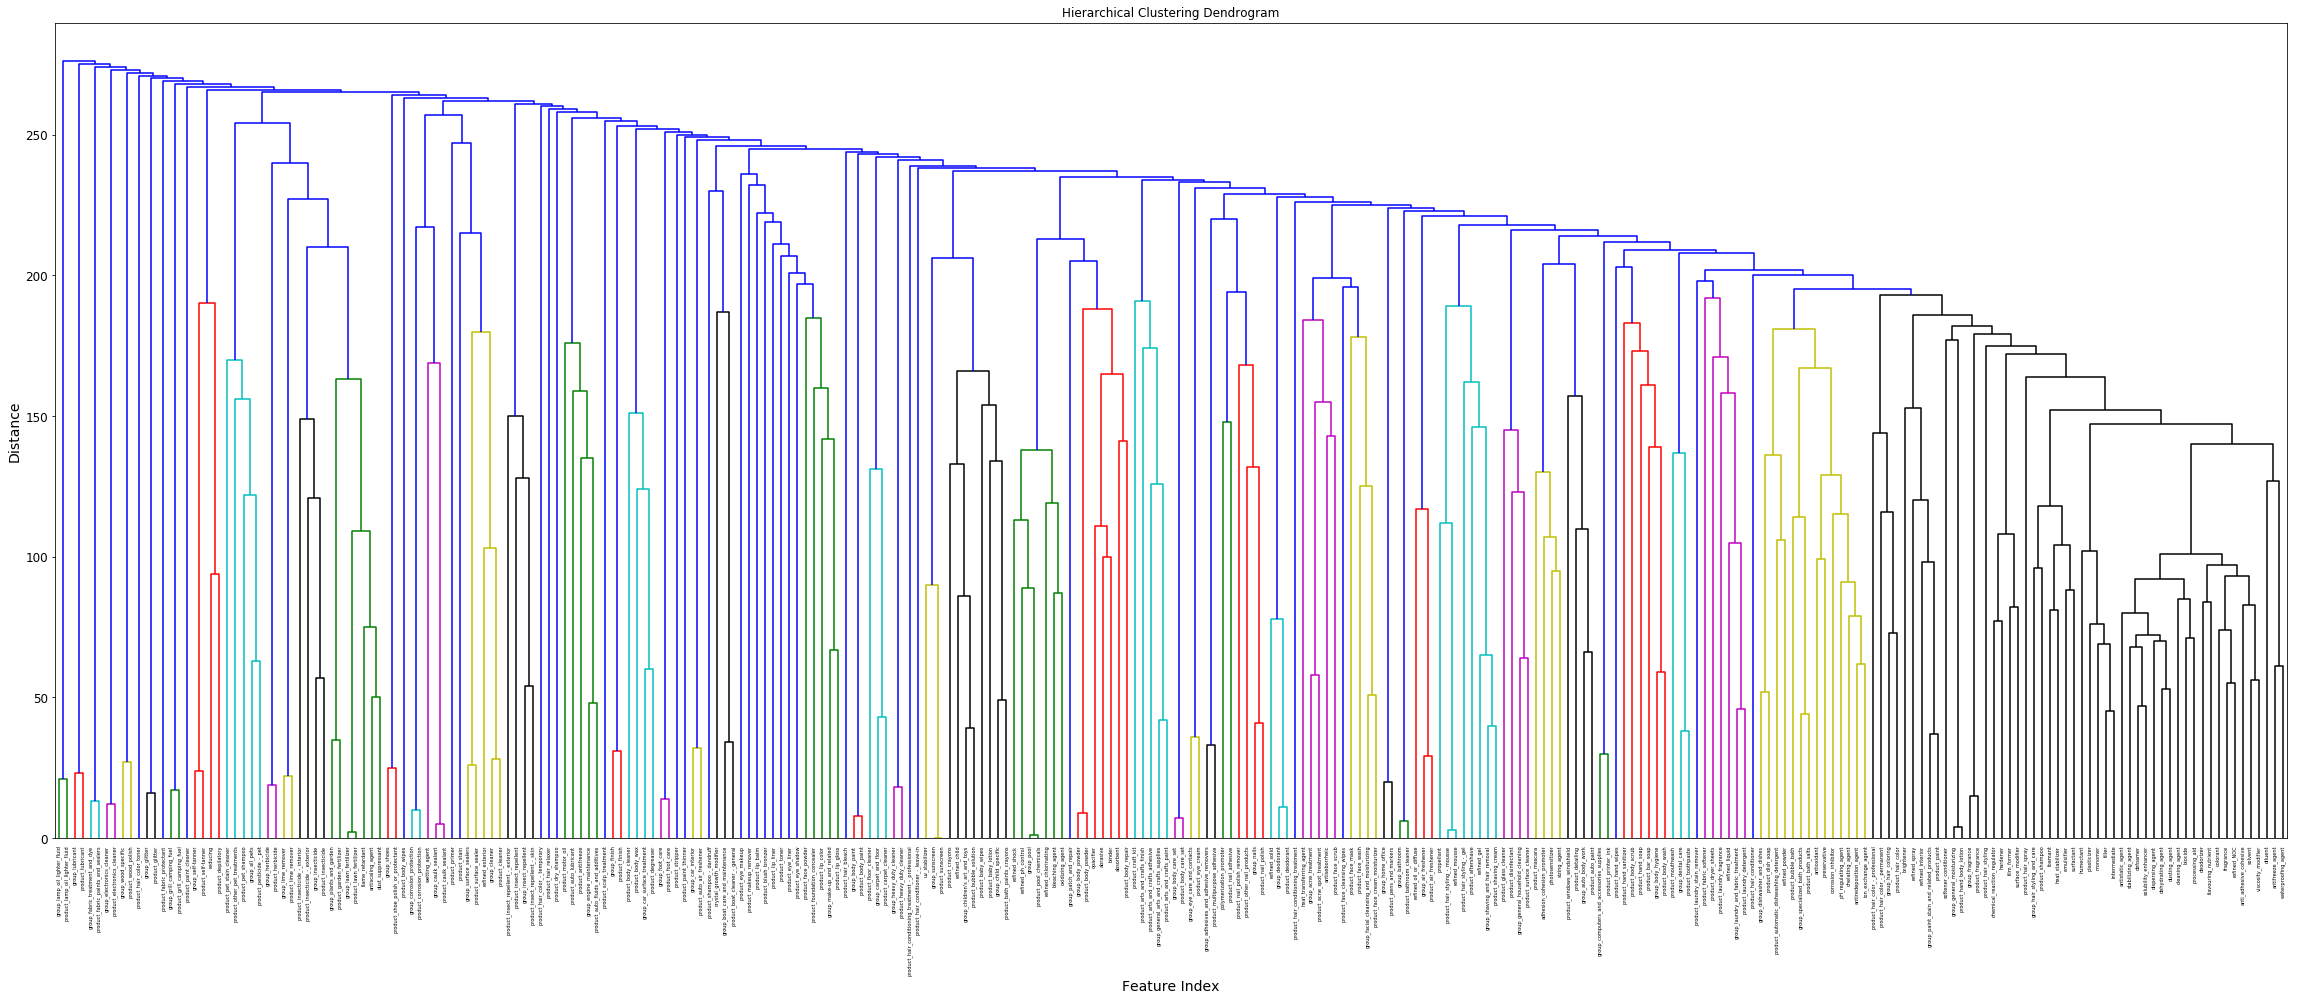

In [80]:
# Functions and product categories dendrogram
fig=plt.figure(figsize=(40, 15))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Feature Index')
plt.ylabel('Distance')
plot_dendrogram(agg, labels=feat_names)
plt.show()
savepdf(fig,'sklearn_dendrogram_both2')

In [81]:
# Feature Agglomeration (Clustering)
# Functions
agg = FeatureAgglomeration(n_clusters=2, affinity="cosine", linkage="average")
agg.fit(Xf) #Xf+0.0001

FeatureAgglomeration(affinity='cosine', compute_full_tree='auto',
           connectivity=None, linkage='average', memory=None, n_clusters=2,
           pooling_func=<function mean at 0x10f2402f0>)

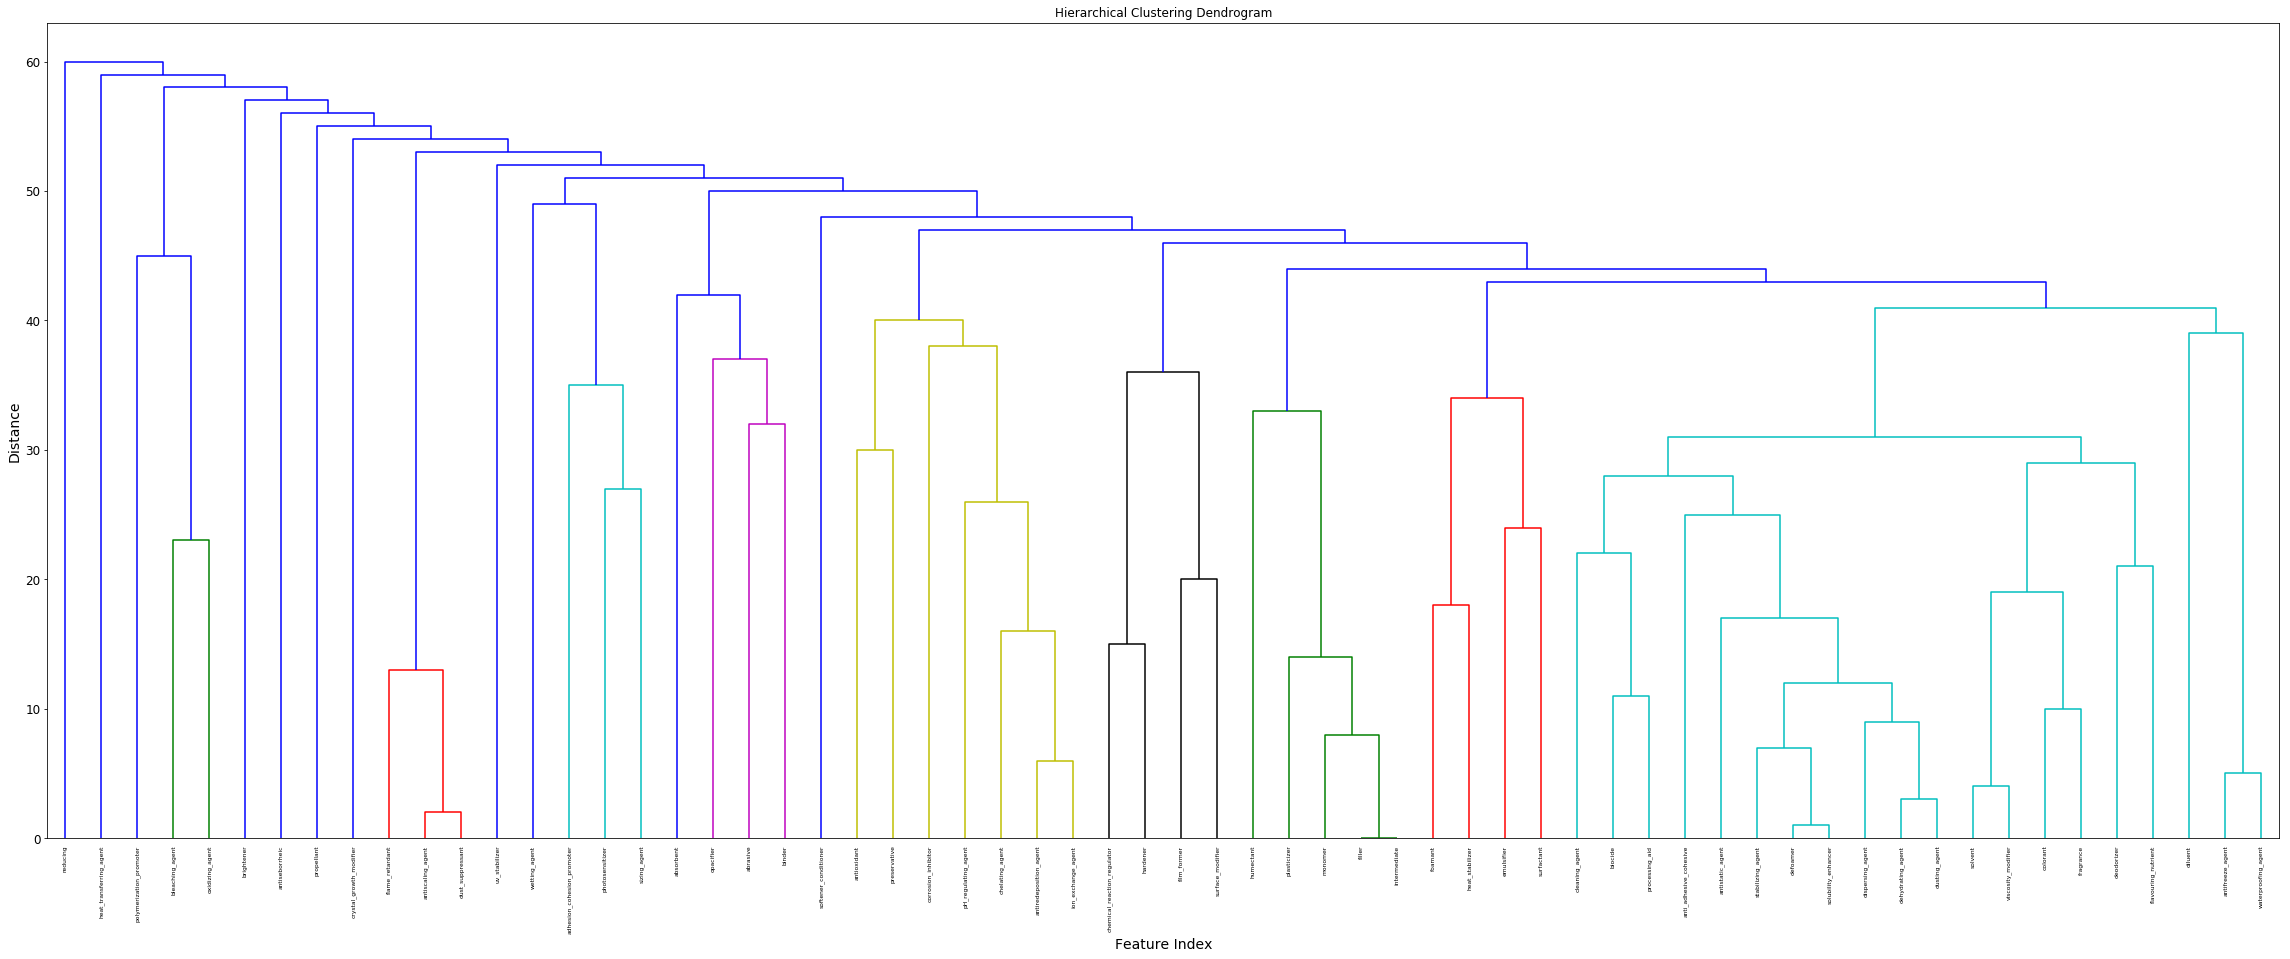

In [82]:
# Functions dendrogram
fig2=plt.figure(figsize=(40, 15))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Feature Index')
plt.ylabel('Distance')
plot_dendrogram(agg, labels=func_names) #
plt.show()
savepdf(fig2,'sklearn_dendrogram_func2')

In [83]:
# Feature Agglomeration (Clustering)
# Product categories
agg = FeatureAgglomeration(n_clusters=18, affinity="cosine", linkage="average") #, compute_full_tree=’auto’
agg.fit(Xp) #Xp+0.0001

FeatureAgglomeration(affinity='cosine', compute_full_tree='auto',
           connectivity=None, linkage='average', memory=None,
           n_clusters=18, pooling_func=<function mean at 0x10f2402f0>)

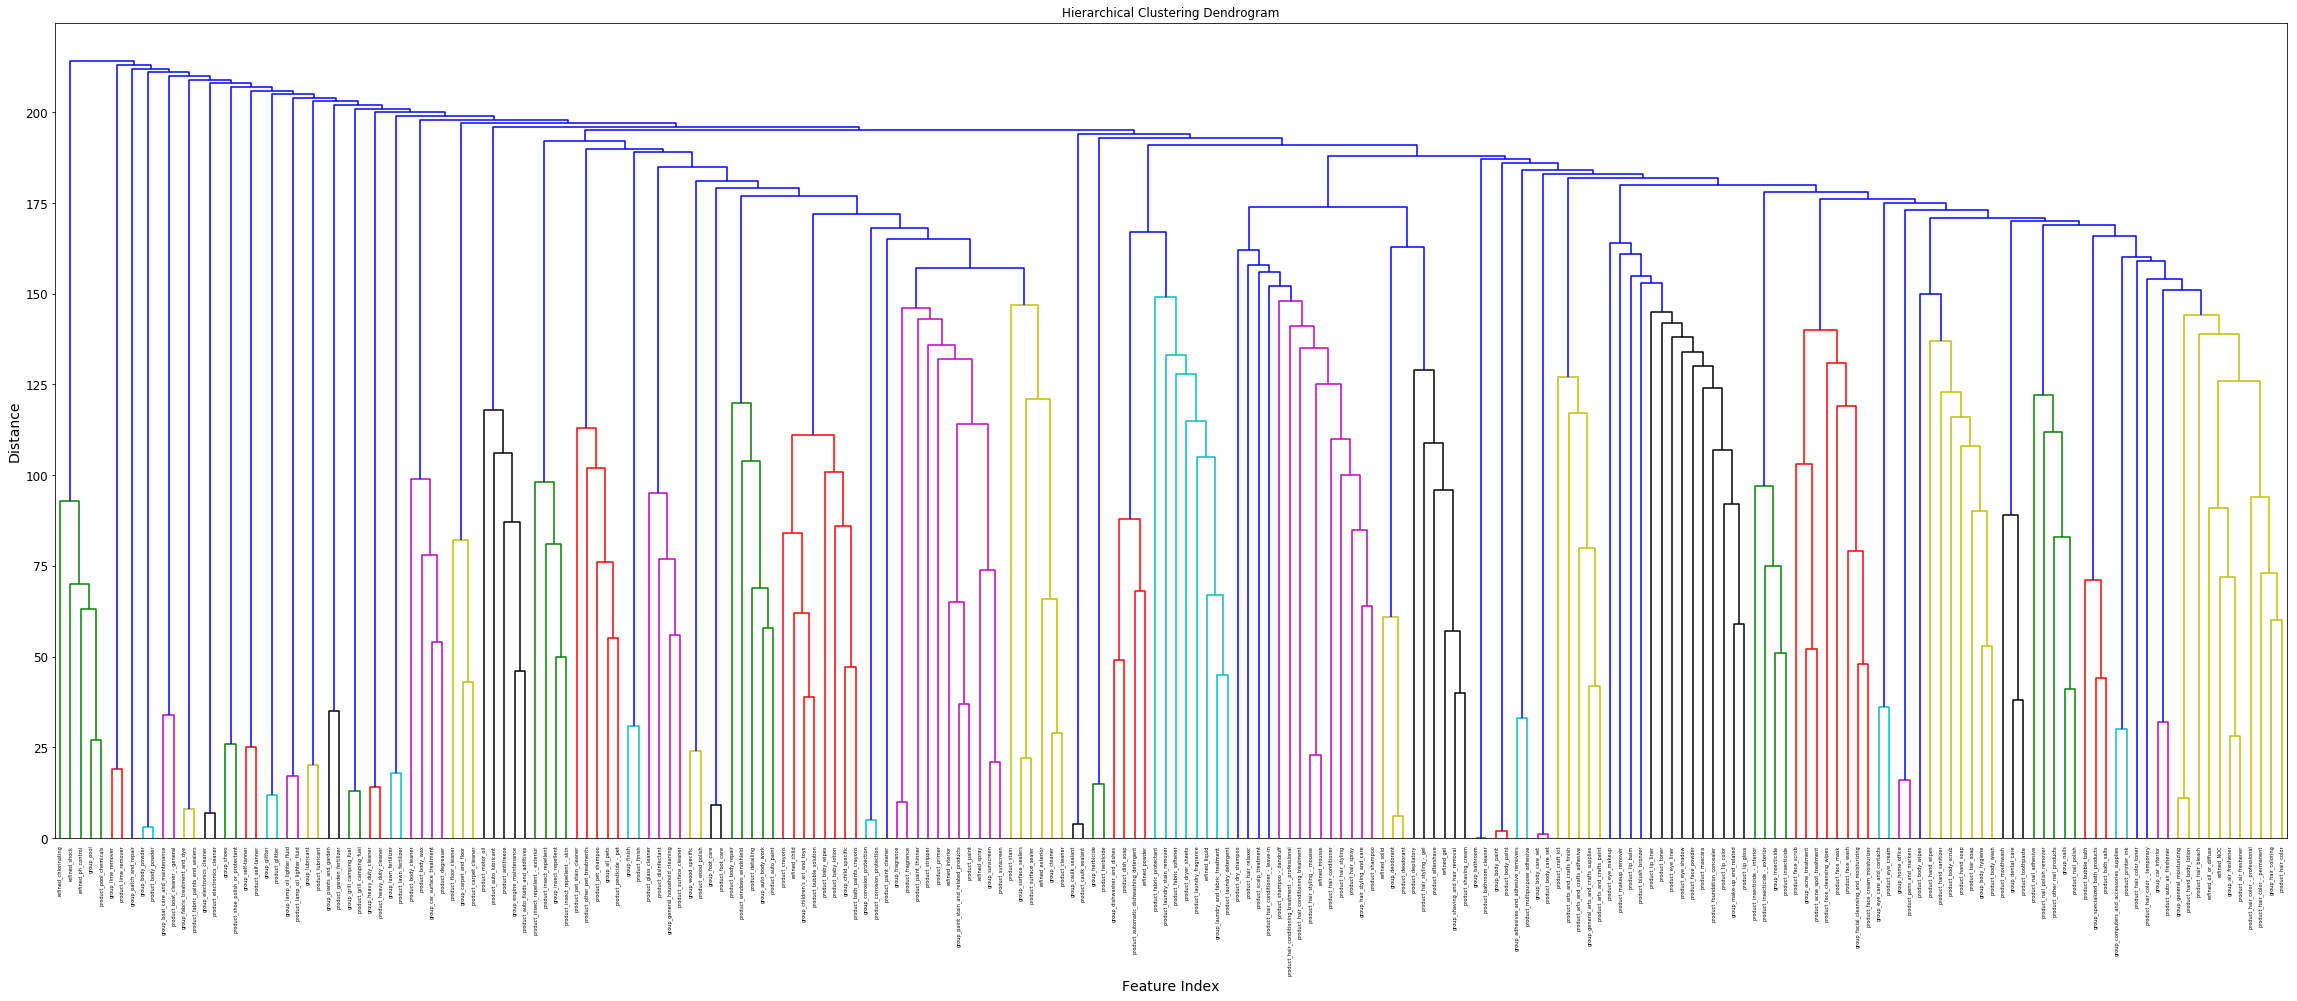

In [84]:
# Product categories dendrogram
fig3=plt.figure(figsize=(40, 15))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Feature Index')
plt.ylabel('Distance')
plot_dendrogram(agg, labels=PUC_names)
plt.show()
savepdf(fig3,'sklearn_dendrogram_PUC2')

### Alternate clustering approach

Alternate approach
https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [45]:
# Distance matrix using cosine
# Functions and Product Category Features

from scipy.spatial.distance import squareform, pdist, cosine
from scipy.cluster.hierarchy import dendrogram, linkage

# https://stackoverflow.com/questions/35639571/python-pandas-distance-matrix-using-jaccard-similarity
res = 1-pdist(X.T, 'cosine') # transform to find similarity between features (not datapoints)
distance = pd.DataFrame(squareform(res), index=feat_names, columns=feat_names)
#distance

NameError: name 'X' is not defined

In [46]:
# Distance matrix using Jaccard similarity
# Functions only

from scipy.spatial.distance import squareform, pdist, jaccard
from scipy.cluster.hierarchy import dendrogram, linkage

res1 = 1-pdist(Xf.T, 'jaccard') # transform to find similarity between features (not datapoints)
distance1 = pd.DataFrame(squareform(res1), index=func_names, columns=func_names)
#distance1

NameError: name 'Xf' is not defined

In [47]:
# Distance matrix using cosine
# Functions only

from scipy.spatial.distance import squareform, pdist, cosine
from scipy.cluster.hierarchy import dendrogram, linkage

res2 = 1-pdist(Xf.T, 'cosine') # transform to find similarity between features (not datapoints)
distance2 = pd.DataFrame(squareform(res2), index=func_names, columns=func_names)
#distance2

NameError: name 'Xf' is not defined

In [79]:
###############
# Distance matrix using cosine
# ENM Functions and Product Category Features

from scipy.spatial.distance import squareform, pdist, cosine
from scipy.cluster.hierarchy import dendrogram, linkage

# https://stackoverflow.com/questions/35639571/python-pandas-distance-matrix-using-jaccard-similarity
res_enm = 1-pdist(Xfp_enm.T, 'cosine') # transform to find similarity between features (not datapoints)
distance_enm = pd.DataFrame(squareform(res_enm), index=enm_all_names, columns=enm_all_names)

In [80]:
distance_enm

,absorbent,antioxidant,antiredeposition_agent,biocide,brightener,chemical_reaction_regulator,colorant,deodorizer,filler,flavouring_nutrient,...,group_nutritional supplements,group_paint/stain and related products,group_portable air processing,group_sunscreen,group_surface sealers,group_toys,refined_NOC,refined_spray,matrix_A,matrix_F
absorbent,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.478091,0.000000,...,0.000000,0.000000,0.000000,0.149071,0.000000,0.000000,0.215353,0.124035,0.000000,0.273179
antioxidant,0.000000,0.000000,0.000000,0.111803,0.000000,0.000000,0.000000,0.000000,0.000000,0.301511,...,0.301511,0.000000,0.000000,0.000000,0.000000,0.000000,0.170251,0.000000,0.000000,0.172774
antiredeposition_agent,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.353553,0.000000,0.188982,0.000000,...,0.000000,0.408248,0.000000,0.000000,0.000000,0.000000,0.085126,0.196116,0.000000,0.172774
biocide,0.000000,0.111803,0.000000,0.000000,0.000000,0.000000,0.000000,0.223607,0.000000,0.438230,...,0.438230,0.091287,0.158114,0.000000,0.000000,0.158114,0.609110,0.350823,0.612372,0.482917
brightener,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.136083,0.000000,0.000000,0.294884,0.000000,0.000000,0.299253
chemical_reaction_regulator,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.170251,0.000000,0.000000,0.172774
colorant,0.000000,0.000000,0.353553,0.000000,0.000000,0.000000,0.000000,0.000000,0.133631,0.000000,...,0.000000,0.577350,0.000000,0.166667,0.000000,0.000000,0.240772,0.000000,0.000000,0.244339
deodorizer,0.000000,0.000000,0.000000,0.223607,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.085126,0.196116,0.182574,0.086387
filler,0.478091,0.000000,0.188982,0.000000,0.000000,0.000000,0.133631,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.534522,0.000000,0.000000,0.321745,0.296500,0.000000,0.457116
flavouring_nutrient,0.000000,0.301511,0.000000,0.438230,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.564660,0.000000,0.000000,0.573025


In [81]:
# Organics Functions and Product Category Features
from textwrap import wrap
fig=plt.imshow(distance)
#plt.title('Distance Matrix (Cosine) of Function and Product Category Features')
plt.title("\n".join(wrap("Distance Matrix (Cosine) of Function and Product Category Features", 60)))
plt.colorbar()
plt.savefig('./BLTfigs/distmatrix_function-PUC_cosine.png')

NameError: name 'distance' is not defined

In [82]:
fig=plt.imshow(distance1)
plt.title('Distance Matrix (Jaccard Similarity) of Function Features')
plt.colorbar()
plt.savefig('./BLTfigs/distmatrix_function_only_jaccard.png')

NameError: name 'distance1' is not defined

In [83]:
fig=plt.imshow(distance2)
plt.title('Distance Matrix (Cosine) of Function Features')
plt.colorbar()
plt.savefig('./BLTfigs/distmatrix_function_only_cosine.png')

NameError: name 'distance2' is not defined

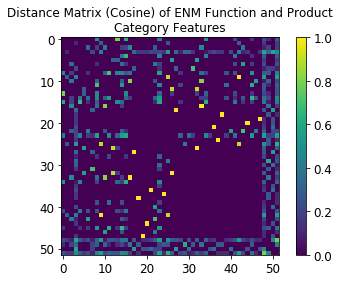

In [84]:
# ENM Functions and Product Category Features
from textwrap import wrap
fig=plt.imshow(distance_enm)
#plt.title('Distance Matrix (Cosine) of Function and Product Category Features')
plt.title("\n".join(wrap("Distance Matrix (Cosine) of ENM Function and Product Category Features", 60)))
plt.colorbar()
plt.savefig('./BLTfigs/enm_distmatrix_function-PUC_cosine.png')

In [85]:
# Generate linkage matrix
# Organics Functions only
#https://stackoverflow.com/questions/18952587/use-distance-matrix-in-scipy-cluster-hierarchy-linkage
#https://stackoverflow.com/questions/33721996/how-to-specify-a-distance-function-for-clustering
from scipy.spatial.distance import squareform, pdist, cosine
from scipy.cluster.hierarchy import dendrogram, linkage
#Xfx = Xf+0.0001
Z = linkage((Xf.T), method='average', metric='cosine')

# Z-array with format [idx1, idx2, dist, sample_count]
Z[:5]

NameError: name 'Xf' is not defined

NameError: name 'func_names' is not defined

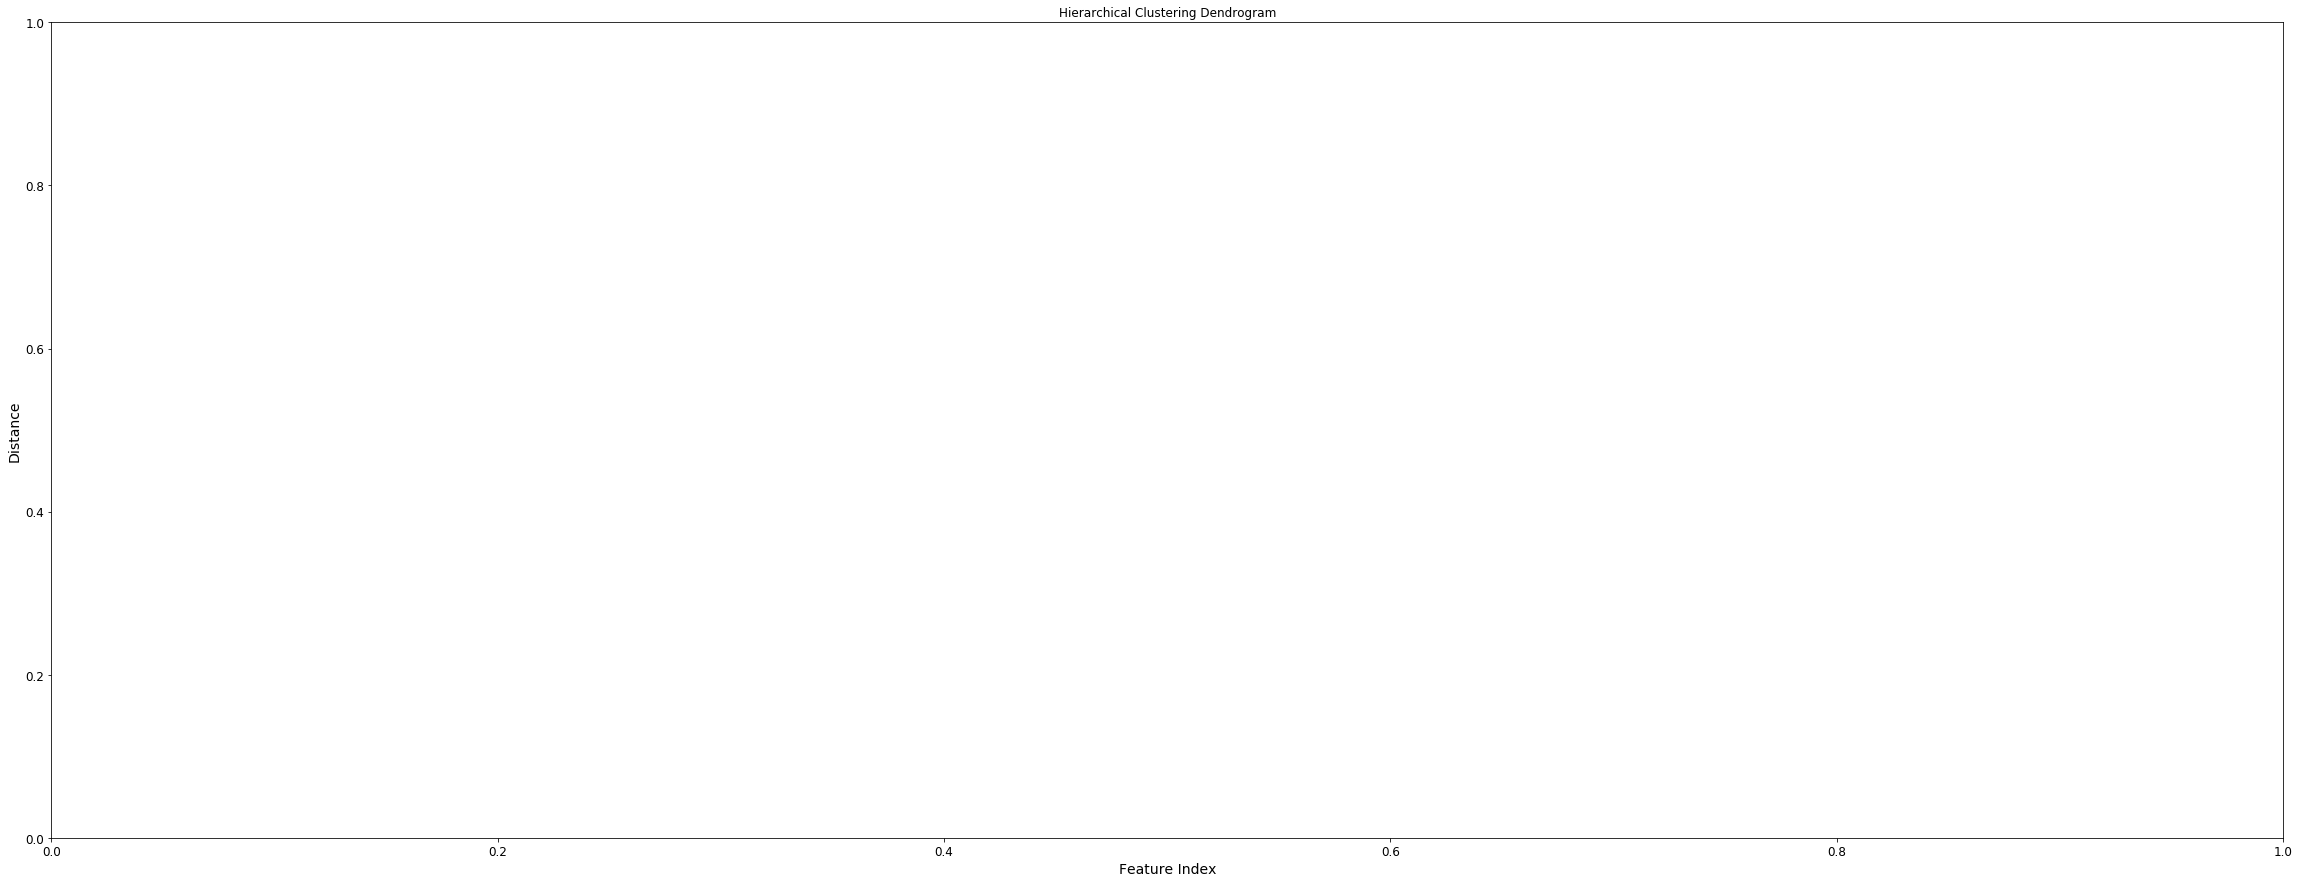

In [86]:
# Calculate full dendrogram
# Organic functions only

fig=plt.figure(figsize=(40, 15))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Feature Index')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
    labels=func_names
)
plt.axhline(y=0.36, color='gray', linestyle='--')
plt.tight_layout() # x-labels don't get cut off
plt.show()
savepdf(fig,'cluster_dendrogram_func-only3')

Reading the dendrogram: heights of the horizontal lines tell you about the distance that needed to be "bridged" to form the new cluster.

Optimize the number of clusters using the elbow method, which estimates the clustering step where the acceleration of distance growth is largest.

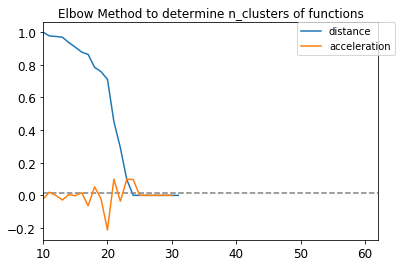

clusters: 21


In [87]:
# Optimize n_clusters with Elbow Method
# Organic functions only

last = Z[-63:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]

plt.plot(idxs, last_rev, label='distance')
plt.axhline(y=0.016, color='gray', linestyle='--')
plt.plot(idxs[:-2] + 1, acceleration_rev, label='acceleration')
plt.title('Elbow Method to determine n_clusters of functions')
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
plt.xlim([10,62])
#plt.ylim([-.05,.1])
plt.savefig('./BLTfigs/elbow_func-only2.png')
plt.show()

k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

# look for spikes in orange

Clusters to try: 17, 27, 32, 46, 55

Do same with product category features.

In [88]:
# Distance matrix using cosine
# Product categories only

from scipy.spatial.distance import squareform, pdist, cosine
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

res2 = 1-pdist(Xp.T, 'cosine') # transform to find similarity between features (not datapoints)
distance2 = pd.DataFrame(squareform(res2), index=PUC_names, columns=PUC_names)
#distance2

NameError: name 'Xp' is not defined

In [89]:
fig=plt.imshow(distance2)
plt.title('Distance Matrix (Cosine) of Product Category Features')
plt.colorbar()
plt.savefig('./BLTfigs/distmatrix_PUC_only_cosine2.png')

NameError: name 'distance2' is not defined

In [90]:
# Generate linkage matrix
# Product categories only

# Z-array with format [idx1, idx2, dist, sample_count]
Z = linkage(Xp.T, method='average', metric='cosine')
Z[:5]

NameError: name 'Xp' is not defined

NameError: name 'PUC_names' is not defined

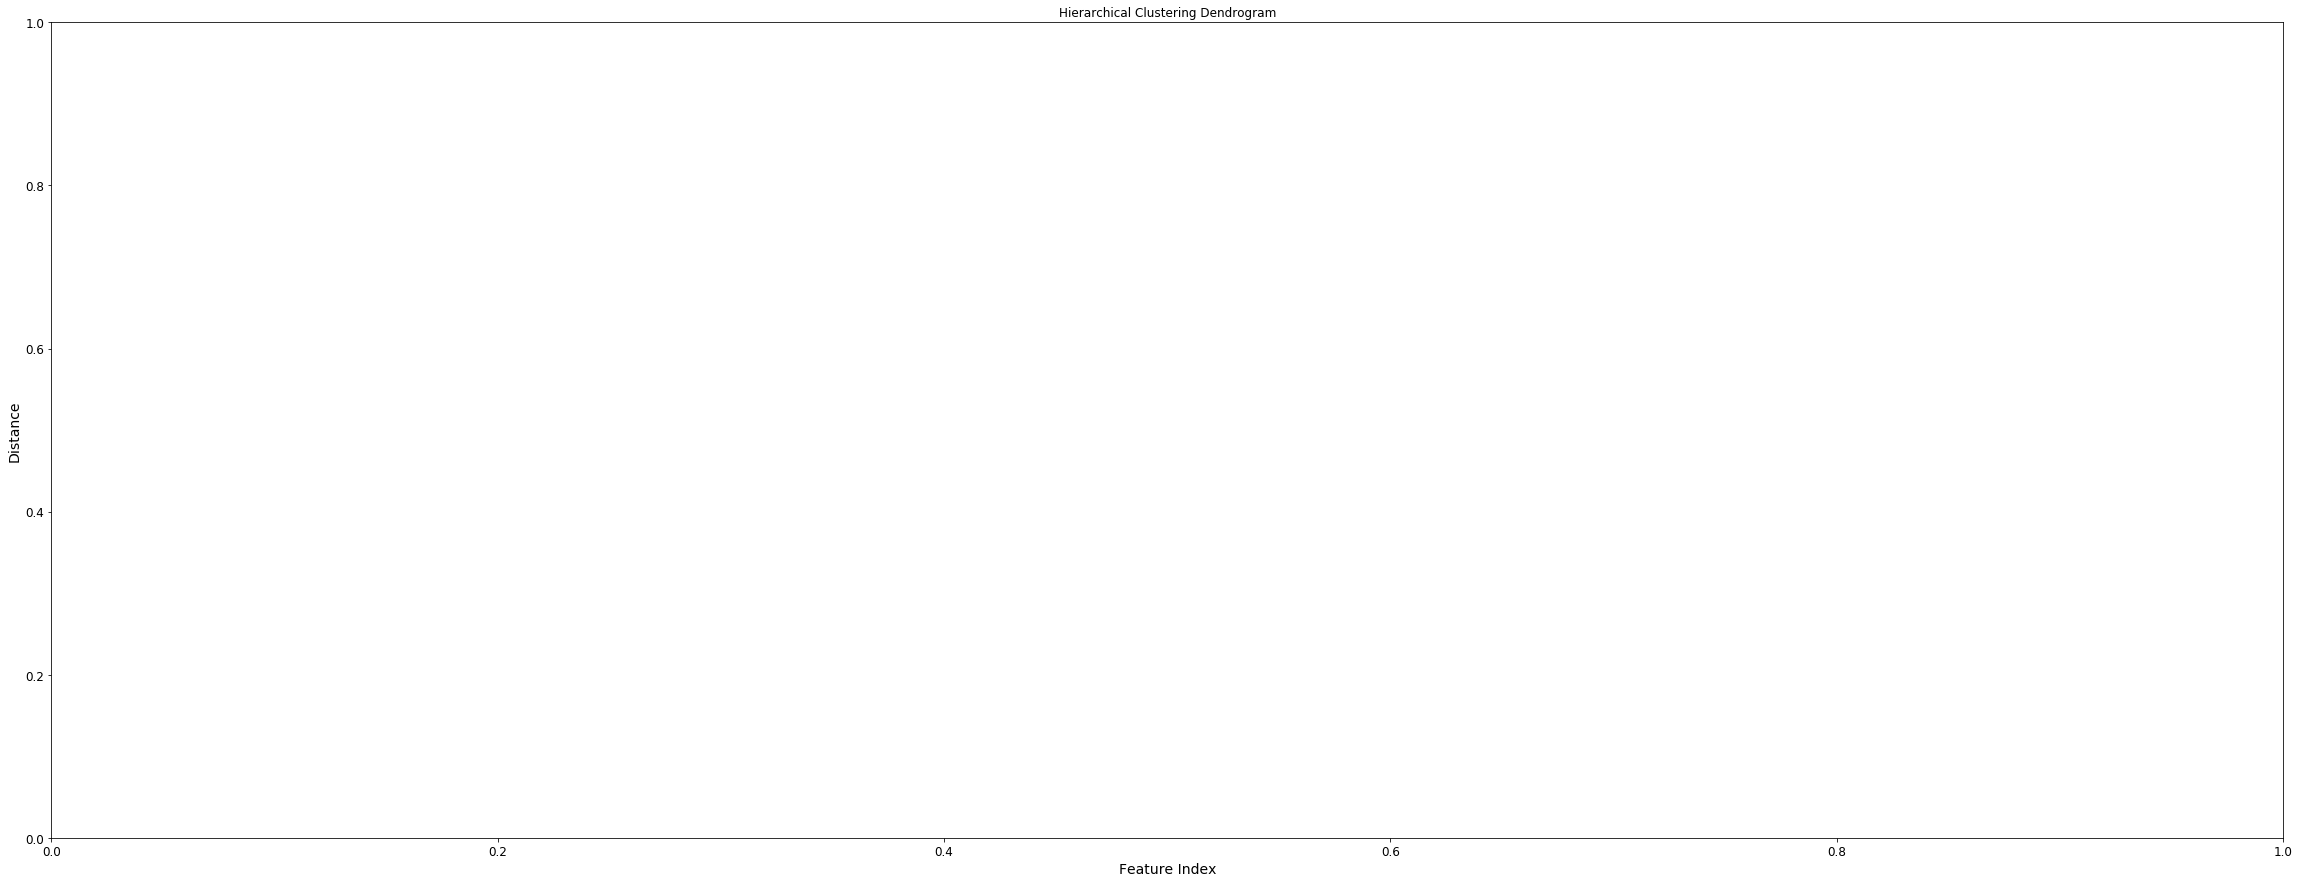

In [91]:
# Calculate full dendrogram
# Product categories only

fig=plt.figure(figsize=(40, 15))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Feature Index')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    labels=PUC_names
)
plt.show()
savepdf(fig,'cluster_dendrogram_PUC-only3')

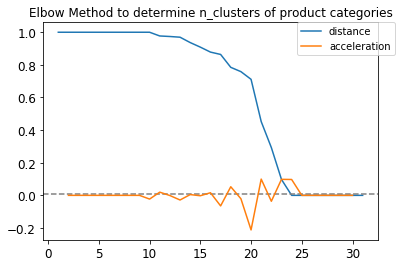

clusters: 21


In [92]:
# Optimize n_clusters with Elbow Method
# Product categories only

last = Z[-216:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]

plt.plot(idxs, last_rev, label='distance')
plt.axhline(y=0.01, color='gray', linestyle='--')
plt.plot(idxs[:-2] + 1, acceleration_rev, label='acceleration')
plt.title('Elbow Method to determine n_clusters of product categories')
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
#plt.xlim([10,40])
#plt.ylim([-.05,.1])
plt.savefig('./BLTfigs/elbow_PUC-only2.png')
plt.show()

k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

# look for spikes in orange

Clusters to try: 183, 176, 156, 147, 134, 106

Now to repeat with ENM functions.

In [93]:
# Generate linkage matrix
# ENM Functions only
from scipy.spatial.distance import squareform, pdist, cosine
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage((Xf_enm.T), method='average', metric='cosine')

# Z-array with format [idx1, idx2, dist, sample_count]
Z[:5]

array([[  0.        ,  13.        ,   0.2       ,   2.        ],
       [  8.        ,  11.        ,   0.29289322,   2.        ],
       [  4.        ,  15.        ,   0.32063378,   2.        ],
       [ 14.        ,  17.        ,   0.48267306,   3.        ],
       [  3.        ,   9.        ,   0.56177009,   2.        ]])

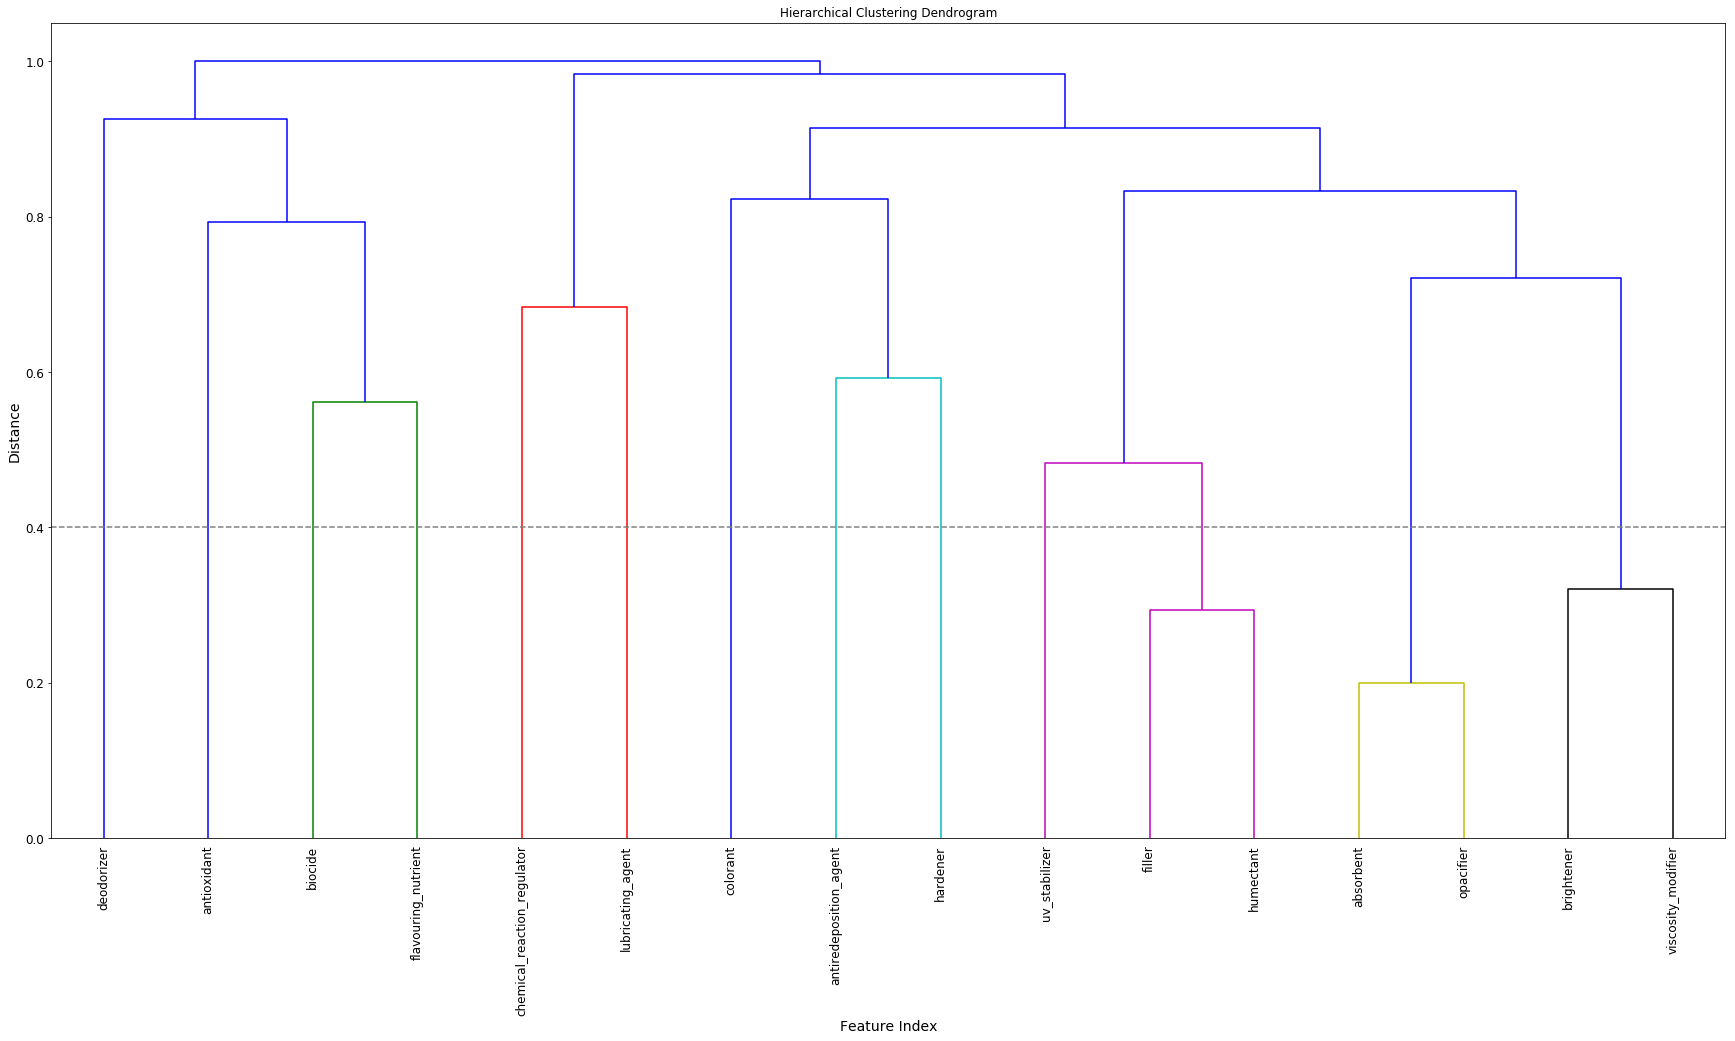

In [94]:
# Calculate full dendrogram
# ENM Functions only

fig=plt.figure(figsize=(30, 15))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Feature Index')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
    labels=enm_func_names
)
plt.axhline(y=0.4, color='gray', linestyle='--')
plt.show()
savepdf(fig,'enm_cluster_dendrogram_func-only')

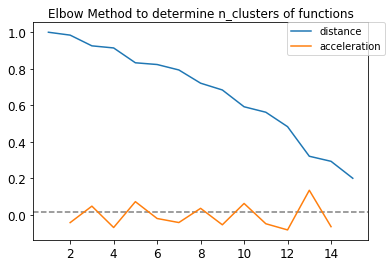

clusters: 13


In [95]:
# Optimize n_clusters with Elbow Method
# Organic functions only

last = Z[-16:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]

plt.plot(idxs, last_rev, label='distance')
plt.axhline(y=0.016, color='gray', linestyle='--')
plt.plot(idxs[:-2] + 1, acceleration_rev, label='acceleration')
plt.title('Elbow Method to determine n_clusters of functions')
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
#plt.xlim([10,62])
#plt.ylim([-.05,.1])
plt.savefig('./BLTfigs/enm_elbow_func-only.png')
plt.show()

k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

# look for spikes in orange
# 13,10,8

Now to repeat with ENM product categories.

In [96]:
# Generate linkage matrix
# ENM PUCs only
Z = linkage((Xp_enm.T), method='average', metric='cosine')
# Z-array with format [idx1, idx2, dist, sample_count]
np.savetxt("./BLTfigs/Z_puc.csv", Z, delimiter=",")

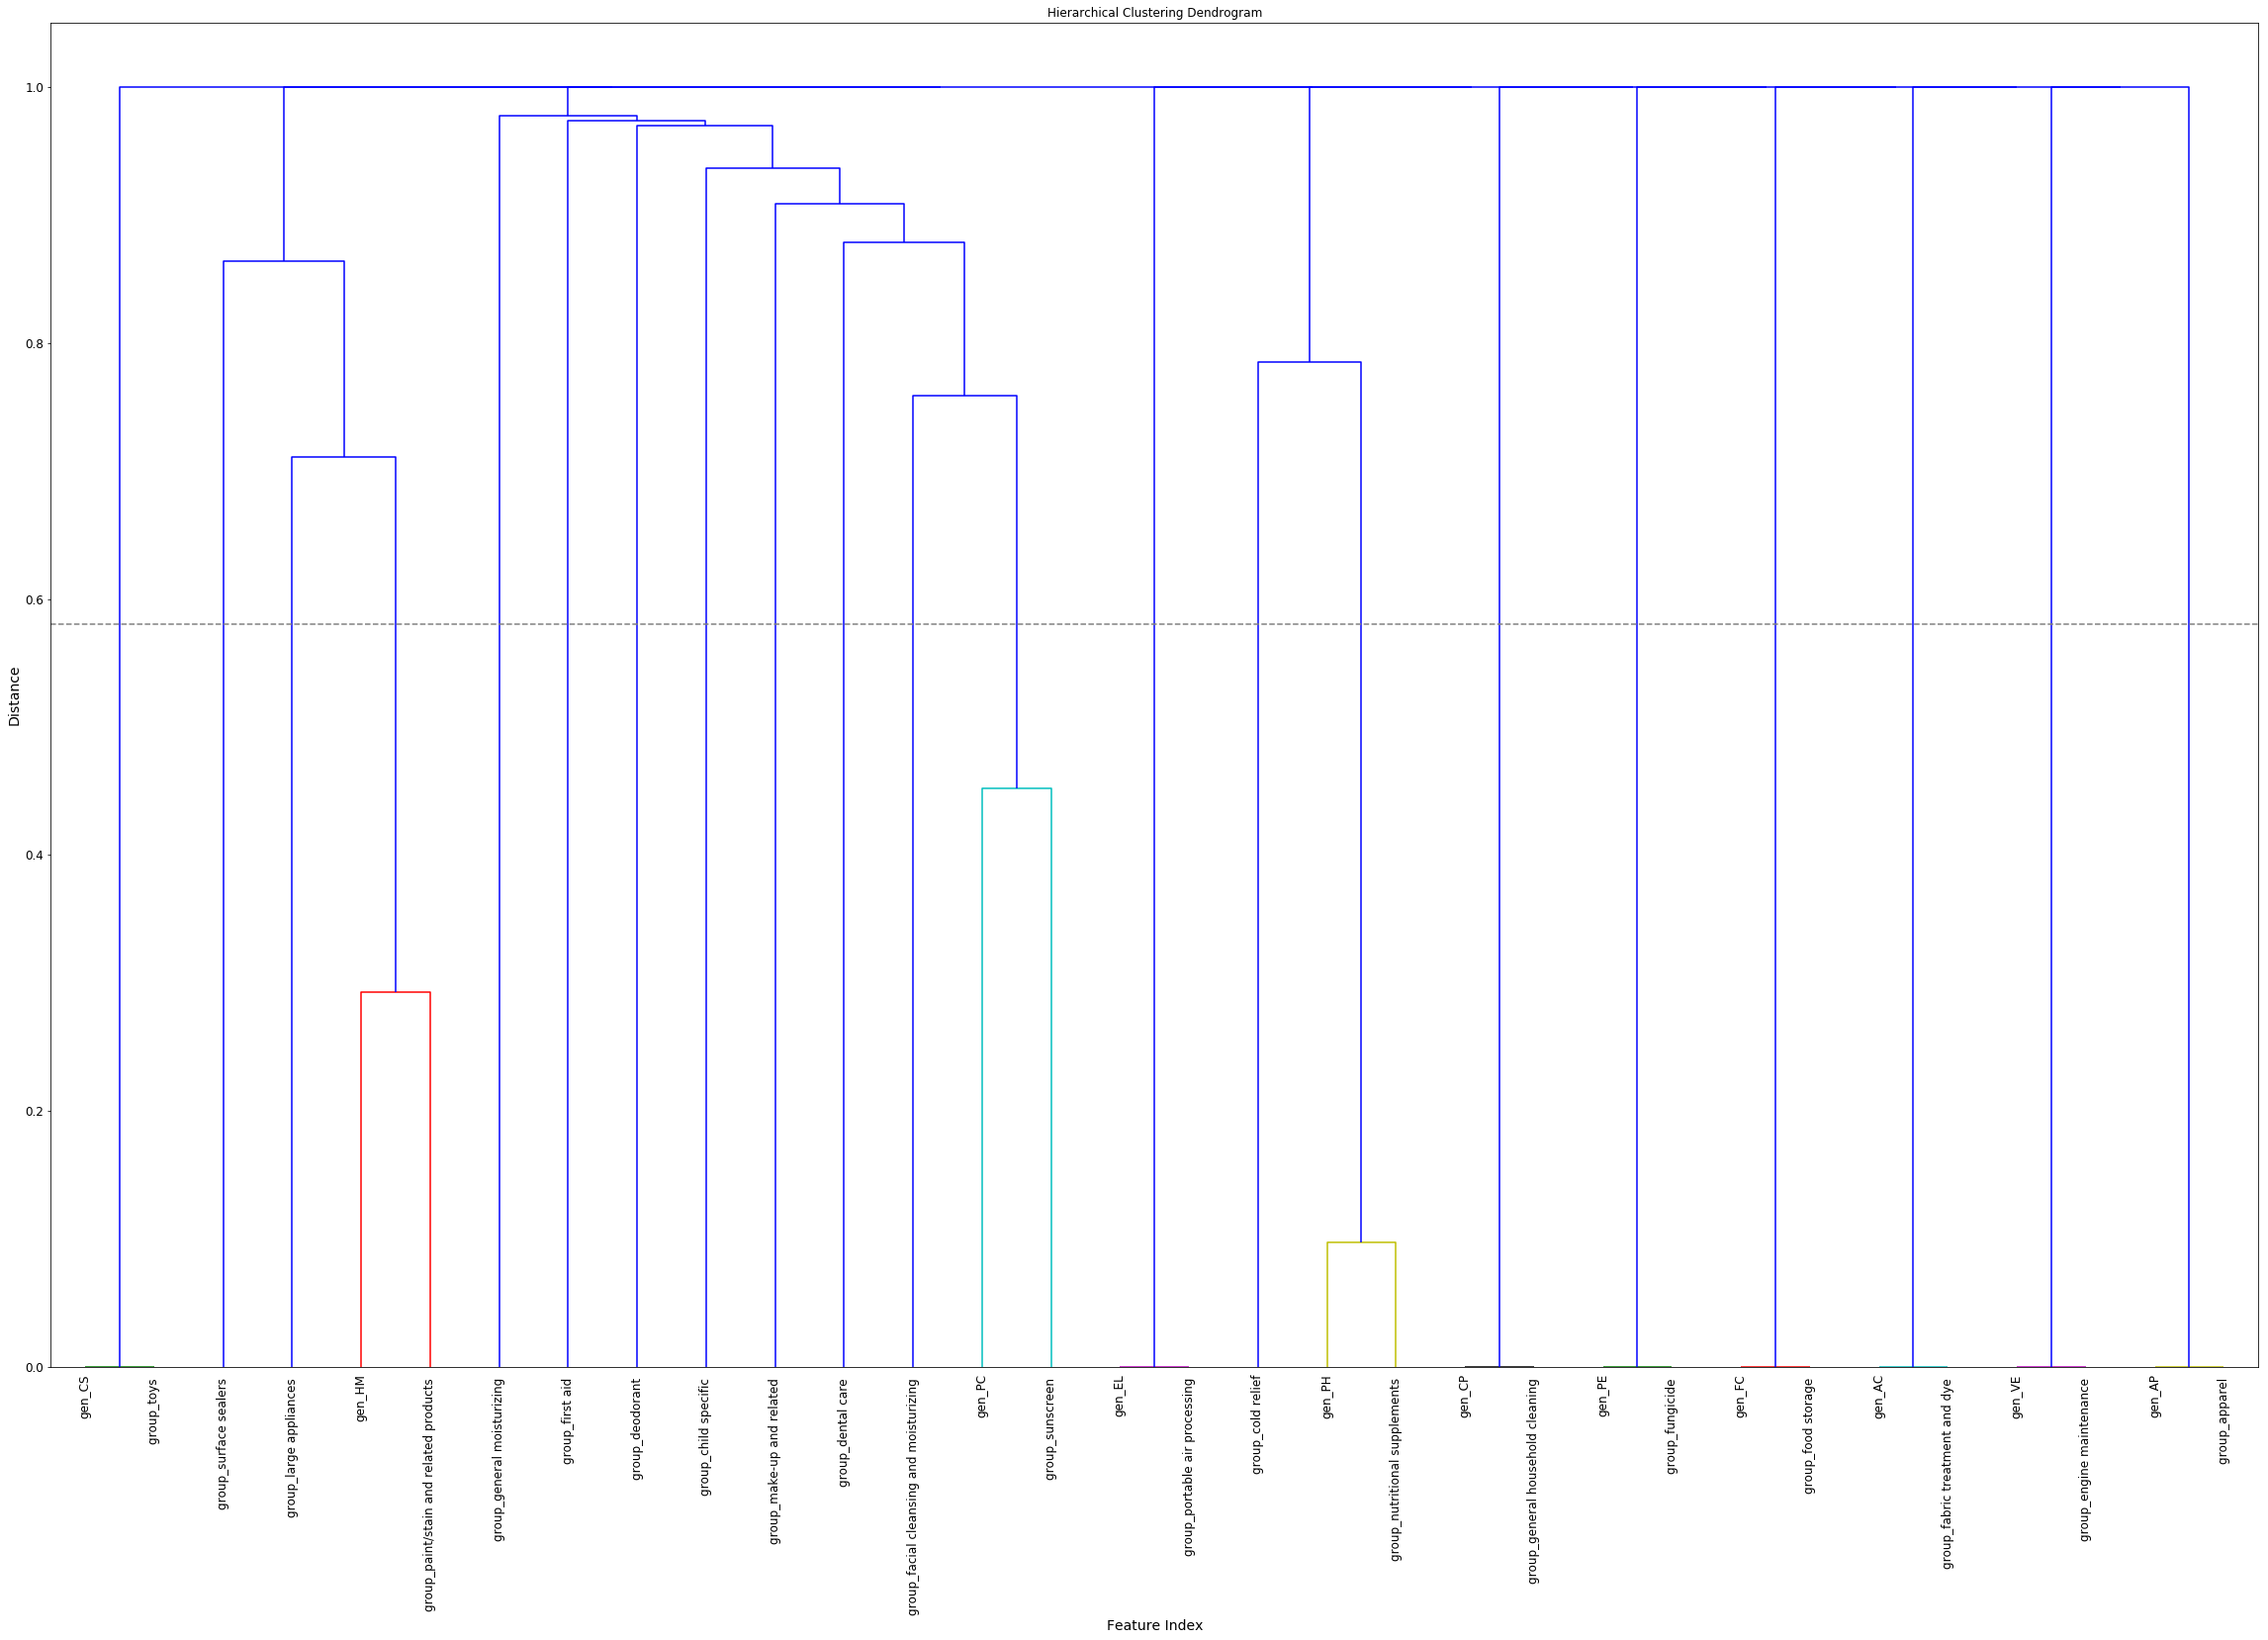

In [97]:
# Calculate full dendrogram
# ENM PUCs only

fig=plt.figure(figsize=(40, 25))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Feature Index')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
    labels=enm_PUC_names
)
plt.axhline(y=0.58, color='gray', linestyle='--')
plt.show()
savepdf(fig,'enm_cluster_dendrogram_PUC-nomatrix')

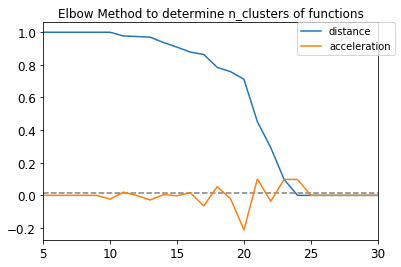

clusters: 21


In [98]:
# Optimize n_clusters with Elbow Method
# Organic functions only

last = Z[-36:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]

plt.plot(idxs, last_rev, label='distance')
plt.axhline(y=0.016, color='gray', linestyle='--')
plt.plot(idxs[:-2] + 1, acceleration_rev, label='acceleration')
plt.title('Elbow Method to determine n_clusters of functions')
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
plt.xlim([5,30])
#plt.ylim([-.05,.1])
plt.savefig('./BLTfigs/enm_elbow_PUC-nomatrix.png')
plt.show()

k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

# look for spikes in orange

Clusters to try: 17, 19, 22, 28

### Helper class for selecting best estimator

Estimator Selection Helper by David Batista
http://www.davidsbatista.net/blog/2018/02/23/model_optimization/

In [194]:
# Set up for grid search across multiple pipelines
from sklearn.model_selection import GridSearchCV

cv=5
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=cv, n_jobs=1, verbose=1, scoring='explained_variance', refit=False): #scoring=None
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})
        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))
                
        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [195]:
# Define sets of models and their respective parameters to compare
# The first dictionary contains the models to be scored
# while the second contains the parameters for each model

from sklearn.cluster import FeatureAgglomeration
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

cv=5
models1 = {
    'RandomForest': RandomForestRegressor(),
    'SVR': SVR()
}

params1 = {
    'RandomForest': { 'n_estimators': [8,16]},
    'SVR': [
        {'kernel': ['linear'], 'C': [1,5]},
        {'kernel': ['rbf'], 'C': [1,5], 'gamma': [0.0001,0.001]},
    ]
}

First use this for Function feature agglomeration.

In [196]:
### RERUN ###
# Fit gridsearch models to select best estimator
# Function features only
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(wf_source_scaled, y_log, n_jobs=3)

# Play sound when cell is done running
Audio(url=sound_file, autoplay=True)

Running GridSearchCV for RandomForest.
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Running GridSearchCV for SVR.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   19.3s finished
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed: 32.6min finished


In [197]:
# Compare performance for estimators (explained variance)
# All features
helper1.score_summary(sort_by='mean_score')

RandomForest
SVR


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



,estimator,min_score,mean_score,max_score,std_score,C,gamma,kernel,n_estimators
7,SVR,0.184443,0.240187,0.31497,0.0437744,5,0.001,rbf,NaN
5,SVR,0.158865,0.214454,0.275221,0.0398153,1,0.001,rbf,NaN
6,SVR,0.149974,0.189547,0.22813,0.0274557,5,0.0001,rbf,NaN
1,RandomForest,-0.174287,0.150295,0.284364,0.1667,NaN,NaN,NaN,16
4,SVR,0.0829107,0.113713,0.164753,0.0274016,1,0.0001,rbf,NaN
2,SVR,-0.151761,0.113324,0.294747,0.168637,1,NaN,linear,NaN
3,SVR,-0.178727,0.103812,0.28937,0.172182,5,NaN,linear,NaN
0,RandomForest,-1.44052,-0.127528,0.258899,0.657629,NaN,NaN,NaN,8


In [199]:
# Fit gridsearch models to select best estimator
# Function features only
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(Xf, y_log, n_jobs=3) # +0.0001

# Play sound when cell is done running
Audio(url=sound_file, autoplay=True)

Running GridSearchCV for RandomForest.
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Running GridSearchCV for SVR.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:  9.5min finished


In [200]:
# Compare performance for estimators (explained variance)
# Function features only
helper1.score_summary(sort_by='mean_score')

RandomForest
SVR


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



,estimator,min_score,mean_score,max_score,std_score,C,gamma,kernel,n_estimators
5,SVR,0.102359,0.149485,0.201202,0.0395036,1,0.001,rbf,NaN
7,SVR,0.110419,0.145686,0.208434,0.033731,5,0.001,rbf,NaN
6,SVR,0.0931025,0.134415,0.174445,0.0319242,5,0.0001,rbf,NaN
4,SVR,0.0531768,0.0827224,0.136342,0.0304263,1,0.0001,rbf,NaN
2,SVR,-0.57542,-0.06533,0.182976,0.26545,1,NaN,linear,NaN
3,SVR,-0.659147,-0.0951944,0.181829,0.296376,5,NaN,linear,NaN
0,RandomForest,-0.738232,-0.199508,0.284018,0.425431,NaN,NaN,NaN,8
1,RandomForest,-0.789507,-0.205047,0.226223,0.41533,NaN,NaN,NaN,16


An SVR-RBF was selected as the best estimator for the function features.

Now for the product category features.

In [201]:
# Fit gridsearch models to select best estimator
# Product category features only
helper2 = EstimatorSelectionHelper(models1, params1)
helper2.fit(Xp, y_log, n_jobs=3) # n_jobs=1 by default

# Play sound when cell is done running
Audio(url=sound_file, autoplay=True)

Running GridSearchCV for RandomForest.
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Running GridSearchCV for SVR.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   38.8s finished
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed: 23.8min finished


In [202]:
# Compare performance for estimators (explained variance)
# Product category features only
helper2.score_summary(sort_by='mean_score')

RandomForest
SVR


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



,estimator,min_score,mean_score,max_score,std_score,C,gamma,kernel,n_estimators
1,RandomForest,0.0293065,0.106218,0.21172,0.0683452,NaN,NaN,NaN,16
0,RandomForest,0.0209716,0.104879,0.208454,0.0707377,NaN,NaN,NaN,8
7,SVR,0.0460199,0.100272,0.166417,0.048692,5,0.001,rbf,NaN
2,SVR,0.0172262,0.0886477,0.185665,0.0683476,1,NaN,linear,NaN
5,SVR,0.0412629,0.0804258,0.13283,0.0362909,1,0.001,rbf,NaN
3,SVR,0.0114224,0.0795685,0.180012,0.0704088,5,NaN,linear,NaN
6,SVR,0.0328885,0.0669293,0.11214,0.0315178,5,0.0001,rbf,NaN
4,SVR,0.014967,0.0268626,0.0463131,0.0114771,1,0.0001,rbf,NaN


An SVR-RBF was also selected as the best estimator for the product category features.

In [204]:
# Define sets of models and their respective parameters to compare
# The first dictionary contains the models to be scored
# while the second contains the parameters for each model

from sklearn.cluster import FeatureAgglomeration
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

cv=5
models1 = {
    'RandomForest': RandomForestRegressor(),
    'SVR': SVR()
}

params1 = {
    'RandomForest': { 'n_estimators': [8,16]},
    'SVR': [
        {'kernel': ['linear'], 'C': [1,5]},
        {'kernel': ['rbf'], 'C': [5, 10], 'gamma': [0.001, 0.005]},
    ]
}

In [205]:
# Fit gridsearch models to select best estimator
# Product category features only
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(Xp, y_log_cut, n_jobs=3) # n_jobs=1 by default

# Play sound when cell is done running
Audio(url=sound_file, autoplay=True)

Running GridSearchCV for RandomForest.
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Running GridSearchCV for SVR.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   41.8s finished
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed: 21.0min finished


In [206]:
# Compare performance for estimators (explained variance)
# Product category features only
helper1.score_summary(sort_by='mean_score')

RandomForest
SVR


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



,estimator,min_score,mean_score,max_score,std_score,C,gamma,kernel,n_estimators
6,SVR,0.0520789,0.114267,0.193659,0.0651152,10,0.001,rbf,NaN
4,SVR,0.0485575,0.113458,0.184712,0.0567085,5,0.001,rbf,NaN
5,SVR,0.0483995,0.113355,0.199707,0.0686832,5,0.005,rbf,NaN
7,SVR,0.048386,0.111475,0.206322,0.0730064,10,0.005,rbf,NaN
1,RandomForest,0.0276157,0.111101,0.245933,0.0892655,NaN,NaN,NaN,16
0,RandomForest,0.0193799,0.110938,0.243827,0.0920382,NaN,NaN,NaN,8
2,SVR,-0.00249175,0.0896177,0.196356,0.0834729,1,NaN,linear,NaN
3,SVR,-0.0105804,0.0779494,0.190128,0.0868199,5,NaN,linear,NaN


### Helper class for bins

In [199]:
# Set up for grid search across multiple pipelines
from sklearn.model_selection import GridSearchCV

cv=5
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=cv, n_jobs=1, verbose=1, scoring='accuracy', refit=False): # scoring=None
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [334]:
# Define sets of models and their respective parameters to compare
# The first dictionary contains the models to be scored
# while the second contains the parameters for each model

from sklearn.cluster import FeatureAgglomeration
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

cv=5
models_b = {
    'RandomForest': RandomForestClassifier(),
    'SVC': SVC()
}

params_b = {
    'RandomForest': { 'n_estimators': [16,24]},
    'SVC': [
        {'kernel': ['linear'], 'C': [1,5]},
        {'kernel': ['rbf'], 'C': [5,10], 'gamma': [0.0001, 0.001]},
    ]
}

In [210]:
# Fit gridsearch models to select best estimator
# All organics features only
helper_b = EstimatorSelectionHelper(models_b, params_b)
helper_b.fit(wf_scaled, bin_num, n_jobs=3)

Running GridSearchCV for RandomForest.
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Running GridSearchCV for SVC.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    5.1s finished
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed: 24.4min finished


In [ ]:
# Compare performance for estimators (accuracy)
# Function features only
helper_b.score_summary(sort_by='mean_score')

In [ ]:
# Fit gridsearch models to select best estimator
# Function features only
helper_b = EstimatorSelectionHelper(models_b, params_b)
helper_b.fit(Xf, y_log, n_jobs=2) # n_jobs=1 by default

In [ ]:
# Compare performance for estimators (accuracy)
# Function features only
helper_b.score_summary(sort_by='mean_score')

For ENM.

In [202]:
# Define sets of models and their respective parameters to compare
# The first dictionary contains the models to be scored
# while the second contains the parameters for each model

from sklearn.cluster import FeatureAgglomeration
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

cv=3
models_b = {
    'RandomForest': RandomForestClassifier(),
    'SVC': SVC()
}

params_b = {
    'RandomForest': { 'n_estimators': [8,16]},
    'SVC': [
        {'kernel': ['linear'], 'C': [10,100]},
        {'kernel': ['rbf'], 'C': [10,100], 'gamma': [0.1,1]},
    ]
}

In [203]:
# Fit gridsearch models to select best estimator
# All organics features only
helper_b = EstimatorSelectionHelper(models_b, params_b)
helper_b.fit(XX_enm+0.00001, bin_num_enm, n_jobs=3)

Running GridSearchCV for RandomForest.
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Running GridSearchCV for SVC.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


KeyboardInterrupt: 

In [ ]:
# Compare performance for estimators (accuracy)
# Function features only
helper_b.score_summary(sort_by='mean_score')

In [287]:
# Fit gridsearch models to select best estimator
# All organics features only
helper_b = EstimatorSelectionHelper(models_b, params_b)
helper_b.fit(Xp_enm, bin_num_enm, n_jobs=3)

Running GridSearchCV for RandomForest.
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=3)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


Running GridSearchCV for SVC.
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed:    0.1s finished


In [288]:
# Compare performance for estimators (accuracy)
# Function features only
helper_b.score_summary(sort_by='mean_score')

RandomForest
SVC


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



,estimator,min_score,mean_score,max_score,std_score,C,gamma,kernel,n_estimators
4,SVC,0.3125,0.440408,0.533333,0.0766597,5,NaN,linear,NaN
5,SVC,0.411765,0.439575,0.466667,0.0175482,0.3,1e-05,rbf,NaN
6,SVC,0.411765,0.439575,0.466667,0.0175482,0.3,0.0001,rbf,NaN
7,SVC,0.411765,0.439575,0.466667,0.0175482,0.3,0.001,rbf,NaN
8,SVC,0.411765,0.439575,0.466667,0.0175482,1,1e-05,rbf,NaN
9,SVC,0.411765,0.439575,0.466667,0.0175482,1,0.0001,rbf,NaN
10,SVC,0.411765,0.439575,0.466667,0.0175482,1,0.001,rbf,NaN
11,SVC,0.411765,0.439575,0.466667,0.0175482,5,1e-05,rbf,NaN
12,SVC,0.411765,0.439575,0.466667,0.0175482,5,0.0001,rbf,NaN
13,SVC,0.411765,0.439575,0.466667,0.0175482,5,0.001,rbf,NaN


### Pipeline/GridSearch to select n_clusters

Have to run fit with [X + a very small number] so that features with very few ones don't go missing during cross validation. https://stats.stackexchange.com/questions/324732/kernel-density-estimator-kde-with-too-many-zeroes-as-input

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import FeatureAgglomeration
from sklearn.svm import SVC
#from sklearn import preprocessing

In [477]:
# Pipeline/GridSearch to select n_clusters for feature agglomeration
# after selecting ideal estimator
# Functions only
# Take-2

# Pipeline
feat = FeatureAgglomeration(affinity="cosine", linkage="average")
estimator = SVC(kernel='rbf')
prepipe = Pipeline([
    ('feat', feat),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=5
k_set=[32,46,55]
c_set=[1,5]
gamma_set=[0.0001,0.001]

# Gridsearch
param_grid={'feat__n_clusters': k_set,
            'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=3)
grid_search.fit(Xf+.0001,bin_num)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when cell is done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 1, 'estimator__gamma': 0.001, 'feat__n_clusters': 55}
0.579226686884


In [532]:
# Pipeline/GridSearch to select n_clusters for feature agglomeration
# after selecting ideal estimator
# Functions only
# Take-2

# Pipeline
feat = FeatureAgglomeration(affinity="cosine", linkage="average")
estimator = SVC(kernel='rbf')
prepipe = Pipeline([
    ('feat', feat),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=5
k_set=[61,55,32]
c_set=[1,5]
gamma_set=[0.001,0.01]

# Gridsearch
param_grid={'feat__n_clusters': k_set,
            'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='explained_variance', n_jobs=3)
grid_search.fit(Xf+.0001,bin_num)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when cell is done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 1, 'estimator__gamma': 0.001, 'feat__n_clusters': 55}
-0.0109682869901


In [ ]:
# Pipeline/GridSearch to select n_clusters for feature agglomeration
# after selecting ideal estimator
# Functions only
# Take-2

# Pipeline
feat = FeatureAgglomeration(affinity="cosine", linkage="average")
estimator = SVC(kernel='rbf')
prepipe = Pipeline([
    ('feat', feat),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=5
k_set=[55,32,27]
c_set=[1,10]
gamma_set=[0.0001,0.001]

# Gridsearch
param_grid={'feat__n_clusters': k_set,
            'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='explained_variance', n_jobs=3)
grid_search.fit(Xf+.0001,bin_num)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when cell is done running
Audio(url=sound_file, autoplay=True)

Previously run

In [163]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import FeatureAgglomeration
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
#from sklearn import preprocessing

In [213]:
# Pipeline/GridSearch to select n_clusters for feature agglomeration
# after selecting ideal estimator
# Functions only

# Pipeline
feat = FeatureAgglomeration(affinity="cosine", linkage="average")
estimator = SVR(kernel='rbf')
prepipe = Pipeline([
    ('feat', feat),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=4
k_set=[19,39,48,57]
c_set=[1,10]
gamma_set=[0.0001,0.001]

# Gridsearch
param_grid={'feat__n_clusters': k_set,
            'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='neg_mean_squared_error', n_jobs=-1)
#grid_search.fit(Xf,y)
grid_search.fit(Xf+.0001,y_log)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'estimator__C': 10, 'estimator__gamma': 0.0001, 'feat__n_clusters': 39}
-0.0288307888938


In [214]:
# Test additional n_clusters <116
# Set parameter ranges for gridsearch
# Functions only

cv=4
k_set=[23,35,39,65]
c_set=[10]
gamma_set=[0.0001]

# Gridsearch
param_grid={'feat__n_clusters': k_set,
            'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='neg_mean_squared_error', n_jobs=-1)
#grid_search.fit(Xf,y)
grid_search.fit(Xf+.0001,y_log)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'estimator__C': 10, 'estimator__gamma': 0.0001, 'feat__n_clusters': 39}
-0.0288307888938


In [215]:
# Pipeline/GridSearch to select n_clusters for feature agglomeration
# after selecting ideal estimator
# Product categories only

# Pipeline
feat = FeatureAgglomeration(affinity="cosine", linkage="average")
estimator = SVR(kernel='rbf')
prepipe = Pipeline([
#    ('scale', MinMaxScaler()),
    ('feat', feat),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=4
n_jobs=3
k_set=[114,129,182,217]
c_set=[1,10]
gamma_set=[0.0001,0.001]

# Gridsearch
param_grid={'feat__n_clusters': k_set,
            'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='neg_mean_squared_error', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
#grid_search.fit(Xp,y)
grid_search.fit(Xp+.0001,y_log)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'estimator__C': 10, 'estimator__gamma': 0.001, 'feat__n_clusters': 217}
-0.0295504645876


In [218]:
# Test additional n_clusters <217
# Product categories only

cv=4
n_jobs=3
k_set=[81,114,129]
c_set=[10]
gamma_set=[0.001]

# Gridsearch
param_grid={'feat__n_clusters': k_set,
            'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='neg_mean_squared_error', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
#grid_search.fit(Xp,y)
grid_search.fit(Xp+.0001,y_log)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'estimator__C': 10, 'estimator__gamma': 0.001, 'feat__n_clusters': 81}
-0.0299041517392


In [219]:
# Test additional n_clusters around 81
# Product categories only

cv=4
n_jobs=3
k_set=[73,81,102]
c_set=[10]
gamma_set=[0.001]

# Gridsearch
param_grid={'feat__n_clusters': k_set,
            'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='neg_mean_squared_error', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
#grid_search.fit(Xp,y)
grid_search.fit(Xp+.0001,y_log)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'estimator__C': 10, 'estimator__gamma': 0.001, 'feat__n_clusters': 73}
-0.0298761208171


In [220]:
# Test additional n_clusters <81
# Product categories only

cv=4
n_jobs=3
k_set=[73,63,46]
c_set=[10]
gamma_set=[0.001]

# Gridsearch
param_grid={'feat__n_clusters': k_set,
            'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='neg_mean_squared_error', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
#grid_search.fit(Xp,y)
grid_search.fit(Xp+.0001,y_log)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'estimator__C': 10, 'estimator__gamma': 0.001, 'feat__n_clusters': 73}
-0.0298761208171


In [221]:
# Test additional n_clusters
# Product categories only

cv=4
n_jobs=3
k_set=[73,164,182]
c_set=[10]
gamma_set=[0.001]

# Gridsearch
param_grid={'feat__n_clusters': k_set,
            'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='neg_mean_squared_error', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
#grid_search.fit(Xp,y)
grid_search.fit(Xp+.0001,y_log)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'estimator__C': 10, 'estimator__gamma': 0.001, 'feat__n_clusters': 182}
-0.0297638513504


For functions, {C: 10, gamma: 0.0001, n_clusters: 39}.

For product categories, {C: 10, gamma: 0.001, n_clusters: 73}.

### Apply feature agglomeration using optimized n_clusters

In [209]:
# Apply feature agglomeration
# Functions only

agg = FeatureAgglomeration(n_clusters=32, affinity="cosine", linkage="average")
Xf_red = agg.fit_transform(Xf+0.0001) # fit to data, then transform it

NameError: name 'FeatureAgglomeration' is not defined

In [210]:
Xf_reddf = pd.DataFrame(Xf_red)
print(Xf_reddf.shape)

NameError: name 'Xf_red' is not defined

In [411]:
# Apply feature agglomeration
# Product categories only

agg = FeatureAgglomeration(n_clusters=106, affinity="cosine", linkage="average")
Xp_red = agg.fit_transform(Xp+0.0001) # fit to data, then transform it

In [412]:
Xp_reddf = pd.DataFrame(Xp_red)
print(Xp_reddf.shape)

(18466, 106)


In [413]:
# Concatenate all clustered and scaled features into new dataframe
Xc = pd.DataFrame(data=Xc)
XX = pd.concat([Xc,Xf_reddf,Xp_reddf], axis=1)
#XX.loc[0:3,]
XX=np.array(XX)
print(XX.shape)

(18466, 149)


In [414]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Xc_scaled = scaler.fit_transform(Xc)
Xc_scaleddf = pd.DataFrame(data=Xc_scaled)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [188]:
# Concatenate all clustered and scaled features into new dataframe
XX_scaled = pd.concat([Xc_scaleddf,Xf_reddf,Xp_reddf], axis=1)
#XX.loc[0:3,]
XX_scaled=np.array(XX_scaled)
print(XX_scaled.shape)

(18466, 148)


# Core models

## Model with clustering, regression

In [189]:
# Define sets of models and their respective parameters to compare
# The first dictionary contains the models to be scored
# while the second contains the parameters for each model

#from sklearn import model_selection, metrics
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

njobs=3
models3 = {
    'RandomForest': RandomForestRegressor(),
    'SVR': SVR()
}

params3 = {
    'RandomForest': { 'n_estimators': [16, 32] },
    'SVR': [
        {'kernel': ['linear'], 'C': [1, 10]},
        {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.001, 0.0001]},
    ]
}

In [190]:
# Fit gridsearch models to select best estimator

helper3 = EstimatorSelectionHelper(models3, params3)
helper3.fit(XX_scaled+0.0001, y_log, n_jobs=n_jobs, scoring='explained_variance') # n_jobs=1 by default

Running GridSearchCV for RandomForest.
Fitting 4 folds for each of 2 candidates, totalling 8 fits
Running GridSearchCV for SVR.
Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=3)]: Done   8 out of   8 | elapsed:   13.7s finished
[Parallel(n_jobs=3)]: Done  24 out of  24 | elapsed: 13.7min finished


In [191]:
# Compare performance for estimators
helper3.score_summary(sort_by='mean_score')

RandomForest
SVR


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



,estimator,min_score,mean_score,max_score,std_score,C,gamma,kernel,n_estimators
6,SVR,0.181408,0.235389,0.333006,0.0581024,10,0.001,rbf,NaN
7,SVR,0.130657,0.192446,0.263583,0.049459,10,0.0001,rbf,NaN
4,SVR,0.130558,0.192403,0.263551,0.0494829,1,0.001,rbf,NaN
2,SVR,-0.0478509,0.119079,0.248771,0.117397,1,NaN,linear,NaN
5,SVR,0.0314226,0.0573698,0.069992,0.0153253,1,0.0001,rbf,NaN
3,SVR,-0.131118,0.0404863,0.222609,0.125494,10,NaN,linear,NaN
0,RandomForest,-1.08712,-0.101413,0.293497,0.570551,NaN,NaN,NaN,16
1,RandomForest,-1.71474,-0.236531,0.368963,0.857433,NaN,NaN,NaN,32


## Model with PCA, regression

In [195]:
# Fit gridsearch models to select best estimator

helper2 = EstimatorSelectionHelper(models3, params3)
helper2.fit(dim_red, y_log, n_jobs=n_jobs, scoring='explained_variance') # n_jobs=1 by default

Running GridSearchCV for RandomForest.
Fitting 4 folds for each of 2 candidates, totalling 8 fits
Running GridSearchCV for SVR.
Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=3)]: Done   8 out of   8 | elapsed:   24.1s finished
[Parallel(n_jobs=3)]: Done  24 out of  24 | elapsed:  6.5min finished


In [196]:
# Compare performance for estimators
helper2.score_summary(sort_by='mean_score')

RandomForest
SVR


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



,estimator,min_score,mean_score,max_score,std_score,C,gamma,kernel,n_estimators
4,SVR,0.162767,0.208766,0.2824,0.0463174,1,0.001,rbf,NaN
7,SVR,0.162846,0.208663,0.282249,0.04622,10,0.0001,rbf,NaN
6,SVR,0.0843965,0.19016,0.336038,0.0982342,10,0.001,rbf,NaN
2,SVR,-0.0441376,0.13565,0.330196,0.150264,1,NaN,linear,NaN
3,SVR,-0.0456671,0.134709,0.32938,0.150663,10,NaN,linear,NaN
1,RandomForest,-0.0299161,0.103178,0.241841,0.130373,NaN,NaN,NaN,32
0,RandomForest,-0.0595416,0.0962785,0.232918,0.132716,NaN,NaN,NaN,16
5,SVR,0.0479669,0.0909964,0.118614,0.0271788,1,0.0001,rbf,NaN


In [109]:
# Pipeline/GridSearch to find best optimized model
# after selecting ideal estimator

# Pipeline
estimator = SVR(kernel='rbf')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=4
n_jobs=3
c_set=[5,10,15]
gamma_set=[0.001,0.01]

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='explained_variance', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
#grid_search.fit(XX,y_log)
grid_search.fit(XX+.0001,y_log)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'estimator__C': 5, 'estimator__gamma': 0.001}
0.189540980007


Try after adding 10^-6 to y_log

In [228]:
# Pipeline/GridSearch to find best optimized model
# after selecting ideal estimator

# Pipeline
estimator = SVR(kernel='rbf')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=4
n_jobs=3
c_set=[5]
gamma_set=[0.0003]

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='explained_variance', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
#grid_search.fit(XX,y_log)
grid_search.fit(XX+.0001,y_log)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'estimator__C': 5, 'estimator__gamma': 0.0003}
0.247951378691


### Evaluate model without product categories

In [192]:
# Concatenate all clustered and scaled features into new dataframe
XXwo = pd.concat([Xc_scaleddf,Xf_reddf], axis=1)
XXwo_scaled=np.array(XXwo)
print(XXwo_scaled.shape)

(18466, 42)


In [193]:
# Fit gridsearch models to select best estimator
# estimated variance

helper3 = EstimatorSelectionHelper(models3, params3)
helper3.fit(XXwo_scaled+0.0001, y_log, n_jobs=n_jobs, scoring='explained_variance') 

Running GridSearchCV for RandomForest.
Fitting 4 folds for each of 2 candidates, totalling 8 fits
Running GridSearchCV for SVR.
Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=3)]: Done   8 out of   8 | elapsed:    3.8s finished
[Parallel(n_jobs=3)]: Done  24 out of  24 | elapsed:  5.0min finished


In [194]:
# Compare performance for estimators
helper3.score_summary(sort_by='mean_score')

RandomForest
SVR


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



,estimator,min_score,mean_score,max_score,std_score,C,gamma,kernel,n_estimators
6,SVR,0.0918576,0.190195,0.27218,0.0645974,10,0.001,rbf,NaN
7,SVR,0.11591,0.17574,0.245221,0.0525884,10,0.0001,rbf,NaN
4,SVR,0.115861,0.175737,0.245163,0.0525934,1,0.001,rbf,NaN
5,SVR,0.0293069,0.0543393,0.0665254,0.0150271,1,0.0001,rbf,NaN
2,SVR,-0.081444,0.0526751,0.200449,0.1235,1,NaN,linear,NaN
0,RandomForest,-0.270645,0.0366894,0.323001,0.22152,NaN,NaN,NaN,16
3,SVR,-0.19972,-0.0373581,0.172809,0.135355,10,NaN,linear,NaN
1,RandomForest,-0.508223,-0.051572,0.312178,0.320532,NaN,NaN,NaN,32


## Model with PCA, WF Bins

In [535]:
# PREP DATA

# Scale the data first (i.e., the chemical properties) so everything is from 0 to 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
wf_scaled = scaler.fit_transform(X_source)

from sklearn import decomposition 
pca=decomposition.PCA(n_components=46)
dim_red=pca.fit_transform(wf_scaled)

Define helper class from earlier.

In [536]:
# Set up for grid search across multiple pipelines
from sklearn.model_selection import GridSearchCV

cv=5
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=cv, n_jobs=1, verbose=1, scoring='accuracy', refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [537]:
# Define sets of models and their respective parameters to compare
# The first dictionary contains the models to be scored
# while the second contains the parameters for each model

from sklearn.cluster import FeatureAgglomeration
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

cv=5
models1 = {
    'RandomForest': RandomForestClassifier(),
    'SVC': SVC()
}

params1 = {
    'RandomForest': { 'n_estimators': [8, 16] },
    'SVC': [
        {'kernel': ['linear'], 'C': [1, 5]},
        {'kernel': ['rbf'], 'C': [1, 5], 'gamma': [0.001, 0.0001]},
    ]
}

In [538]:
# Fit gridsearch models to select best estimator
# Take2
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(dim_red, bin_num, n_jobs=3) # n_jobs=1 by default

# Play sound when done running
Audio(url=sound_file, autoplay=True)

Running GridSearchCV for RandomForest.
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Running GridSearchCV for SVC.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:  7.9min finished


In [539]:
# Compare performance for estimators
# Explained variance
helper1.score_summary(sort_by='mean_score')

RandomForest
SVC


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



,estimator,min_score,mean_score,max_score,std_score,C,gamma,kernel,n_estimators
4,SVC,0.563769,0.666145,0.745395,0.0604423,1,0.001,rbf,NaN
7,SVC,0.562145,0.657212,0.743229,0.0618239,5,0.0001,rbf,NaN
6,SVC,0.485784,0.634193,0.74675,0.0967791,5,0.001,rbf,NaN
2,SVC,0.417276,0.596179,0.737811,0.114214,1,NaN,linear,NaN
3,SVC,0.419171,0.595204,0.737811,0.112581,5,NaN,linear,NaN
1,RandomForest,0.434064,0.550362,0.616197,0.0652017,NaN,NaN,NaN,16
5,SVC,0.515028,0.515109,0.515168,6.57264e-05,1,0.0001,rbf,NaN
0,RandomForest,0.424316,0.501407,0.532774,0.0400027,NaN,NaN,NaN,8


In [540]:
# Define sets of models and their respective parameters to compare
# The first dictionary contains the models to be scored
# while the second contains the parameters for each model

from sklearn.cluster import FeatureAgglomeration
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

cv=5
models1 = {
    'RandomForest': RandomForestClassifier(),
    'SVC': SVC()
}

params1 = {
    'RandomForest': { 'n_estimators': [24] },
    'SVC': [
        {'kernel': ['linear'], 'C': [3]},
        {'kernel': ['rbf'], 'C': [1, 3], 'gamma': [0.001, 0.003, 0.01]},
    ]
}

In [541]:
# Fit gridsearch models to select best estimator
# Clustered data
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(XX, bin_num, n_jobs=3) # n_jobs=1 by default

# Play sound when done running
Audio(url=sound_file, autoplay=True)

Running GridSearchCV for RandomForest.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

In [ ]:
# Compare performance for estimators
# Explained variance
helper2.score_summary(sort_by='mean_score')

SVC-RBF performed the best on average. Try optimizing with gridsearch, including preprocessing steps.

### Optimize SVC-RBF

In [147]:
# Pipeline/GridSearch to find best optimized model
# after selecting ideal estimator

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition
from sklearn.svm import SVC

# Pipeline
#estimator = SVC(kernel='rbf')
pipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('feat', decomposition.PCA(n_components=46)),
    ('estimator', SVC(kernel='rbf'))
     ])

# Set parameter ranges for gridsearch
cv=4 # last ran with 5 --> 0.136648
n_jobs=3
c_set=[3,4,5]
gamma_set=[0.0001,0.0003,0.005]

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(pipe,param_grid,cv=cv,scoring='explained_variance', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_source,bin_num)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 5, 'estimator__gamma': 0.0003}
0.136647974002


In [148]:
# Pipeline/GridSearch to find best optimized model
# after selecting ideal estimator

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition
from sklearn.svm import SVC

# Pipeline
#estimator = SVC(kernel='rbf')
pipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('feat', decomposition.PCA(n_components=46)),
    ('estimator', SVC(kernel='rbf'))
     ])

# Set parameter ranges for gridsearch
cv=5
n_jobs=3
c_set=[4,5,6]
gamma_set=[0.0003,0.0005,0.0007]

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(pipe,param_grid,cv=cv,scoring='explained_variance', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_source,bin_num)

#scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
#                                                     len(gamma_range))
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 5, 'estimator__gamma': 0.0003}
0.13847218762


In [ ]:
# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

### Final Organics Model

In [546]:
bestpipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('feat', decomposition.PCA(n_components=46)),
    ('estimator', SVC(kernel='rbf', C=5, gamma=0.0003))
     ])
bestpipe.fit(wf,bin_num)

NameError: name 'wf' is not defined

In [240]:
bestpipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('feat', decomposition.PCA(n_components=46)),
    ('estimator', SVR(kernel='rbf', C=5, gamma=0.0003))
     ])
bestpipe.fit(XX,y_log)

Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feat', PCA(copy=True, iterated_power='auto', n_components=46, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('estimator', SVR(C=5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0003,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [241]:
y_predict=bestpipe.predict(XX)

In [208]:
# Check model performance
#y_blind_predict=bestpipe.predict_proba(X_blind)

from sklearn import metrics
metrics.roc_auc_score(np.log(y),y_predict[:,1])

IndexError: too many indices for array

Text(0.5,1,'predicted vs actual')

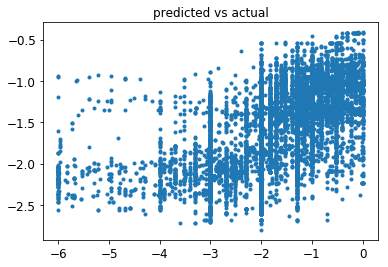

In [242]:
# AFTER adjusting y_log
plt.plot(y_log,y_predict,'.')
plt.title('predicted vs actual')

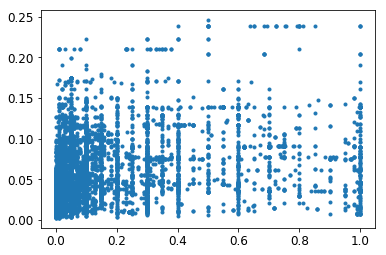

In [235]:
plt.plot(np.exp(y_log),np.exp(y_predict),'.')

Text(0.5,1,'predicted vs actual')

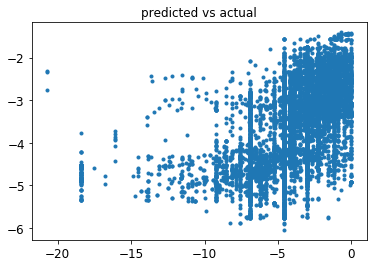

In [227]:
# BEFORE
plt.plot(np.log(y),y_predict,'.')
plt.title('predicted vs actual')

In [ ]:
# add in offset (e.g., 1/10,000) when I take the y-log
# what threshold is actually reasonable for my model?
# be sure to state limitations